# BB84 QKD Parameters Optimization

## Fiber Lengths and n_X Values
Fiber lengths are created from 0 to 200 km in 0.1 km steps, resulting in 2001 unique fiber lengths. \
$n_X$ values are used ranging from $10^6$ to $10^{10}$, creating 5 unique values. \
Form all combinations of fiber lengths and $n_X$, resulting in 2001 $\times$ 5 = 10,005 combinations, which aligns with the aim to generate a large dataset.

## Optimization Process:
For each combination of fiber length $L$ and $n_X$, The parameters $\vec{p}$ = $ [ \mu_1, \mu_2, P_{\mu_1}, P_{\mu_2}, P_X ]$ are optimized using dual_annealing, which is a global optimization algorithm. \
The objective function is wrapped to evaluate the key rate for a specific combination of fiber length and $n_X$. 

## Parallelization:
joblib’s Parallel is used to run the optimization for all combinations in parallel, with 12 threads, making the process efficient. \
tqdm-joblib is also used to track progress visually. 

## Dataset Creation:
The results of the optimization ($e_1, e_2, e_3, e_4, n_X, R, p_{opt}$) are collected into a dataset. \
This dataset is saved to a file (training_dataset.json) for training a neural network. 




## Setup

### Framework Selection:JAX
Functional Programming: Simplify scientific computation and optimization workflows. \
Smaller Footprint: Ideal if the project doesn’t leverage TensorFlow’s broader ecosystem.

##### Key Considerations
For numerically intensive workloads (e.g., optimization tasks like QKD key rate calculations), JAX excels due to its lightweight functional paradigm.

##### Conclusion
Use JAX for performance-critical, purely numerical optimization tasks with minimal dependencies on machine learning frameworks.

## Imports

In [1]:
# Import necessary libraries
import os
import sys
import time
import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
from scipy.optimize import minimize, dual_annealing, differential_evolution, Bounds

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp, gamma
from jax.experimental import pjit
from jax.sharding import Mesh

# SciPy imports
from math import exp, factorial

# JAX configuration for double precision
jax.config.update("jax_enable_x64", True)

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
print(jax.devices())

[CpuDevice(id=0)]


## Experimental Parameters

In [3]:
# e_1
# Fiber lengths
Ls = jnp.linspace(1e-12, 200, 200)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100
    
#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value
# 2.7*10** -7
# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
# e_2 = -jnp.log(Y_0)

# e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10 ** s for s in range(4, 15)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = n_X_values
e_4 = N

## Other Parameters

In [4]:
alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability
# 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
kappa = 1e-15           # given in the paper
f_EC = 1.16             # given in the paper, range around 1.1


## Optimal Paramters

In [5]:
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

## Functions

The calculate_factorial function provided uses the gamma function to compute the factorial of a number  n . This is mathematically correct because the gamma function  \Gamma(n+1)  is equivalent to the factorial  n!  for non-negative integers  n .

## Mathematical Background
The gamma function is defined as:
$\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} \, dt$ \
For positive integers, the gamma function satisfies the relationship: \
$\Gamma(n + 1) = n!$
\
JAX does not have a built-in factorial function, but it does support the gamma function. This makes the approach valid and compatible with JAX for automatic differentiation and JIT compilation.

In [19]:
from QKD_KeyRate_ParameterOptimization.QKD_Functions.QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

ModuleNotFoundError: No module named 'QKD_KeyRate_ParameterOptimization'

In [15]:
pwd

'/Users/daai6ga1hou2/Documents/GitHub/QKD_KeyRate_ParameterOptimization/Optimization'

In [7]:
# bounds = [
#     (4e-4, 0.9),  # mu_1 (ensure within a reasonable range)
#     (2e-4, 0.5),  # mu_2 (less than mu_1)
#     (1e-12, 1.0-1e-12),  # P_mu_1
#     (1e-12, 1.0),  # P_mu_2
#     (1e-12, 1.0),  # P_X_value
# ]

In [8]:
# def optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
#     """
#     Optimize key rates for a given fiber length and n_X value using dual annealing 
#     and Nelder-Mead optimization, ensuring parameters remain within bounds.
#     """
#     L, n_X = input_params

#     def wrapped_objective(params):
#         # Negative because we minimize, but key rates need maximization
#         return -objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]

# # Step 1: Perform global optimization using dual annealing with initial guess x0
#     if x0 is not None:
#         global_result = dual_annealing(
#             func=wrapped_objective,
#             bounds=bounds,
#             initial_temp=20,  # Reduced initial temperature
#             restart_temp_ratio=1e-8,  # Adjusted if needed
#             visit=2.0,  # Adjusted if needed
#             accept=-15.0,
#             x0=x0  # Use the provided initial guess
#         )
#     else:
#         global_result = dual_annealing(
#             func=wrapped_objective,
#             bounds=bounds,
#             initial_temp=20,  # Reduced initial temperature
#             restart_temp_ratio=1e-8,  # Adjusted if needed
#             visit=2.0,  # Adjusted if needed
#             accept=-15.0,
#         )

#     # Step 2: Refine results using local optimization (Nelder-Mead)
#     local_result = minimize(
#         fun=wrapped_objective,
#         x0=global_result.x,  # Start from global optimization result
#         method='Nelder-Mead',
#         options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}  # Tighter tolerances and increased maxiter
#     )

#     # Extract the optimized parameters and key rate
#     optimized_params = local_result.x
#     optimized_key_rate = -local_result.fun  # Convert back to key rate (positive)

#     # Validate the optimized parameters against the bounds
#     out_of_bounds = any(
#         param < b[0] or param > b[1]
#         for param, b in zip(optimized_params, bounds)
#     )

#     if not out_of_bounds:
#         return L, n_X, optimized_key_rate, optimized_params

#     # If parameters are out of bounds, return NaN results
#     print("Parameters out of bounds.")
#     return L, n_X, float('nan'), [float('nan')] * len(bounds)

In [9]:
def optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, max_retries=10):
    """
    Optimize key rates for a given fiber length and n_X value using dual annealing 
    and Nelder-Mead optimization, ensuring parameters remain within bounds and retry
    if log10(key_rate) > 0.
    """
    L, n_X = input_params

    def wrapped_objective(params):
        # Negative because we minimize, but key rates need maximization
        return -objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]

    best_key_rate = float('-inf')
    best_params = None

    for attempt in range(max_retries):
        try:
            # Step 1: Perform global optimization using dual annealing
            global_result = dual_annealing(
                func=wrapped_objective,
                bounds=bounds,
                initial_temp=20,  # Reduced initial temperature
                restart_temp_ratio=1e-8,  # Adjusted if needed
                visit=2.0,  # Adjusted if needed
                accept=-15.0,
                #   x_0  # Adjusted if needed,

            )

            # Step 2: Refine results using local optimization (Nelder-Mead)
            local_result = minimize(
                fun=wrapped_objective,
                x0=global_result.x,  # Start from global optimization result
                method='Nelder-Mead',
                options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}  # Tighter tolerances and increased maxiter
            )
            # Extract the optimized parameters and key rate
            optimized_params = local_result.x
            optimized_key_rate = -local_result.fun  # Convert back to key rate (positive)

            # Validate the optimized parameters against the bounds
            out_of_bounds = any(
                param < b[0] or param > b[1]
                for param, b in zip(optimized_params, bounds)
            )

            # Retry if key rate is abnormal (log10(key_rate) > 0)
            if np.log10(max(optimized_key_rate, 1e-10)) > 0:
                print(f"Attempt {attempt + 1}: Abnormal key rate detected (log10 > 0). Retrying...")
                continue

            if not out_of_bounds:
                # If all parameters are valid, update best results if key rate is improved
                if optimized_key_rate > best_key_rate:
                    best_key_rate = optimized_key_rate
                    best_params = optimized_params

                # Stop retrying if parameters stabilize
                if best_params is not None and np.allclose(best_params, optimized_params, atol=1e-4):
                    break
            else:
                print(f"Attempt {attempt + 1}: Parameters out of bounds. Retrying...")

        except Exception as e: 
            print(f"Attempt {attempt + 1}: Optimization error: {e}. Retrying...")

    if best_params is not None:
        return L, n_X, best_key_rate, best_params

    # If we exhaust retries, raise an error or return NaN results
    print(f"Optimization failed after {max_retries} retries.")
    return L, n_X, float('nan'), [float('nan')] * len(bounds)

In [10]:
initial_guess = [0.325684, 0.008542, 0.601268, 0.810905, 0.681594]
initial_guesses = {n_X: {} for n_X in n_X_values}  # Store last optimized p per n_X and L
bounds = [
    (4e-4, 0.9),  # mu_1 (ensure within a reasonable range)
    (2e-4, 0.5),  # mu_2 (less than mu_1)
    (1e-12, 1.0-1e-12),  # P_mu_1
    (1e-12, 1.0),  # P_mu_2
    (1e-12, 1.0),  # P_X_value
]

In [11]:
def optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, x0=None):
    L, n_X = input_params

    def wrapped_objective(params):
        return -objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]

    # If an initial guess is available, use exponential smoothing
    if x0 is not None:
        smoothed_x0 = 0.7 * np.array(x0) + 0.3 * np.array(initial_guess)  # Adjust the weight if needed
    else:
        smoothed_x0 = initial_guess  # Use default initial guess if none exists

    # Step 1: Perform global optimization using dual annealing with smoothed initial guess
    global_result = dual_annealing(
        func=wrapped_objective,
        bounds=bounds,
        initial_temp=20,
        restart_temp_ratio=1e-8,
        visit=2.0,
        accept=-15.0,
        x0=smoothed_x0  # Use smoothed initial guess
    )

    # # Step 2: Refine results using local optimization (Nelder-Mead)
    # local_result = minimize(
    #     fun=wrapped_objective,
    #     x0=global_result.x,
    #     method='Nelder-Mead',
    #     options={'maxiter': 5000, 'xatol': 1e-6, 'fatol': 1e-6}
    # )

    # optimized_params = local_result.x
    # optimized_key_rate = -local_result.fun
    optimized_params = global_result.x
    optimized_key_rate = -global_result.fun   

    # Validate bounds
    out_of_bounds = any(param < b[0] or param > b[1] for param, b in zip(optimized_params, bounds))

    if not out_of_bounds:
        return L, n_X, optimized_key_rate, optimized_params

    print("Parameters out of bounds.")
    return L, n_X, float('nan'), [float('nan')] * len(bounds)

In [12]:
# from scipy.optimize import dual_annealing, minimize

# def optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, x0=None):
#     """
#     Optimize key rates for a given fiber length and n_X value using dual annealing 
#     and Nelder-Mead optimization, ensuring parameters remain within bounds.
#     """
#     L, n_X = input_params

#     def wrapped_objective(params):
#         # Negative because we minimize, but key rates need maximization
#         return -objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]

#     # Step 1: Perform global optimization using dual annealing with initial guess x0
#     if x0 is not None:
#         global_result = dual_annealing(
#             func=wrapped_objective,
#             bounds=bounds,
#             initial_temp=20,  # Reduced initial temperature
#             restart_temp_ratio=1e-8,  # Adjusted if needed
#             visit=2.0,  # Adjusted if needed
#             accept=-15.0,
#             x0=x0  # Use the provided initial guess
#         )
#     else:
#         global_result = dual_annealing(
#             func=wrapped_objective,
#             bounds=bounds,
#             initial_temp=20,  # Reduced initial temperature
#             restart_temp_ratio=1e-8,  # Adjusted if needed
#             visit=2.0,  # Adjusted if needed
#             accept=-15.0,
#         )

#     # # Step 2: Refine results using local optimization (Nelder-Mead)
#     # local_result = minimize(
#     #     fun=wrapped_objective,
#     #     x0=global_result.x,  # Start from global optimization result
#     #     method='Nelder-Mead',
#     #     options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}  # Tighter tolerances and increased maxiter
#     # )

#     # Extract the optimized parameters and key rate
#     # optimized_params = local_result.x
#     # optimized_key_rate = -local_result.fun  # Convert back to key rate (positive)
#     optimized_params = global_result.x
#     optimized_key_rate = -global_result.fun  # Convert back to key rate (positive)


#     # Validate the optimized parameters against the bounds
#     out_of_bounds = any(
#         param < b[0] or param > b[1]
#         for param, b in zip(optimized_params, bounds)
#     )

#     if not out_of_bounds:
#         return L, n_X, optimized_key_rate, optimized_params

#     # If parameters are out of bounds, return NaN results
#     print("Parameters out of bounds.")
#     return L, n_X, float('nan'), [float('nan')] * len(bounds)

# # Example usage with initial guess and storing result for next iteration
# initial_guess = [0.325684, 0.008542, 0.601268, 0.810905, 0.681594]

# input_params = (1e-12, 1e+04) #  L, n_X



In [13]:
# Initialize dataset storage
categorized_dataset = {n_X: [] for n_X in n_X_values}
# initial_guesses = {n_X: {} for n_X in n_X_values}  # Store last optimized p per n_X and L

In [14]:
n_X_target = 10**4  # Only optimize for n_X = 10^4
initial_guesses = {}  # Store last optimized p for each L

# Ensure proper initialization
categorized_dataset = []

for i, L in enumerate(tqdm(Ls, desc="Generating Dataset")):
    input_params = (L, n_X_target)

    # Use the previous fiber length's optimized parameters if available
    if i > 0:
        previous_L = float(Ls[i - 1])  # Convert previous L to float
        x0 = initial_guesses.get(previous_L, initial_guess)  # Use last optimized parameters
    else:
        x0 = initial_guess  # First iteration uses the initial guess

    result = optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, x0=x0)

    if result:
        L, n_X, key_rate, optimized_params = result
        optimized_params = [float(p) for p in optimized_params]

        # Print the parameters for tracking
        print(f"Iteration {i+1} | L = {L:.4f} km | n_X = {n_X:.0e}")
        print(f"Optimized Key Rate: {key_rate:.6e}")
        print(f"Optimized Parameters: {optimized_params}\n")

        # Store optimized parameters for next fiber length reference
        initial_guesses[float(L)] = optimized_params  

        # Store results in dataset
        categorized_dataset.append({
            'L': float(L),  # Ensure L is stored as a float
            'n_X': n_X,
            'Key Rate': key_rate,
            'Optimized Params': optimized_params
        })

Generating Dataset:   0%|          | 1/200 [00:02<07:38,  2.31s/it]

Iteration 1 | L = 0.0000 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.2434991472178694, 0.2821411770481047, 0.6762598255292277, 0.5703169618373599, 0.15239053342905712]



Generating Dataset:   1%|          | 2/200 [00:03<06:03,  1.84s/it]

Iteration 2 | L = 1.0050 km | n_X = 1e+04
Optimized Key Rate: 4.814387e-04
Optimized Parameters: [0.6398477118335169, 0.154476650148221, 0.0532586827707139, 0.6157143521653416, 0.42358531497866114]



Generating Dataset:   2%|▏         | 3/200 [00:05<05:36,  1.71s/it]

Iteration 3 | L = 2.0101 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.224594025014726, 0.30324354337584725, 0.4516767881897938, 0.9351393523370309, 0.25145881002709686]



Generating Dataset:   2%|▏         | 4/200 [00:06<05:21,  1.64s/it]

Iteration 4 | L = 3.0151 km | n_X = 1e+04
Optimized Key Rate: 4.370898e-04
Optimized Parameters: [0.6406175050466953, 0.1542081321559675, 0.05286769420313745, 0.6165540549306794, 0.4234262043346112]



Generating Dataset:   2%|▎         | 5/200 [00:08<05:09,  1.59s/it]

Iteration 5 | L = 4.0201 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.4012504242439534, 0.463922304161361, 0.577887376463781, 0.9734353344433053, 0.33284116529285107]



Generating Dataset:   3%|▎         | 6/200 [00:10<05:09,  1.59s/it]

Iteration 6 | L = 5.0251 km | n_X = 1e+04
Optimized Key Rate: 3.969448e-04
Optimized Parameters: [0.6382306034951931, 0.15346127848617533, 0.05285066897701007, 0.616711372116872, 0.42369297930765837]



Generating Dataset:   4%|▎         | 7/200 [00:11<05:00,  1.56s/it]

Iteration 7 | L = 6.0302 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.732845908636521, 0.21948335333810096, 0.9172759336841396, 0.9692980257919634, 0.8296717870399439]



Generating Dataset:   4%|▍         | 8/200 [00:12<04:54,  1.53s/it]

Iteration 8 | L = 7.0352 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.7557629919894213, 0.3765962477104577, 0.3575499570994349, 0.43911774687919725, 0.9561725342336215]



Generating Dataset:   4%|▍         | 9/200 [00:14<04:56,  1.55s/it]

Iteration 9 | L = 8.0402 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.00939518421056436, 0.059405164864656426, 0.7736587890167257, 0.27578101345684725, 0.2301606055873481]



Generating Dataset:   5%|▌         | 10/200 [00:16<04:54,  1.55s/it]

Iteration 10 | L = 9.0452 km | n_X = 1e+04
Optimized Key Rate: 3.276459e-04
Optimized Parameters: [0.6341916471175929, 0.15243381897206404, 0.052390795262670625, 0.6168325948445871, 0.42342541314912024]



Generating Dataset:   6%|▌         | 11/200 [00:17<04:58,  1.58s/it]

Iteration 11 | L = 10.0503 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.8547376019316419, 0.1300664566351823, 0.7531248333987899, 0.5304644798421599, 0.2119337676850709]



Generating Dataset:   6%|▌         | 12/200 [00:19<04:54,  1.57s/it]

Iteration 12 | L = 11.0553 km | n_X = 1e+04
Optimized Key Rate: 2.977795e-04
Optimized Parameters: [0.6325380029229082, 0.152256724602393, 0.05259346804660508, 0.616152321672299, 0.4232979606495468]



Generating Dataset:   6%|▋         | 13/200 [00:20<04:52,  1.56s/it]

Iteration 13 | L = 12.0603 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.2911713252103235, 0.4743816582280211, 0.6352546338817237, 0.19255495204990344, 0.19323154486461933]



Generating Dataset:   7%|▋         | 14/200 [00:22<04:49,  1.56s/it]

Iteration 14 | L = 13.0653 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.3369580427802782, 0.3737561235996752, 0.18754147675419694, 0.7821663403524551, 0.9153758724867954]



Generating Dataset:   8%|▊         | 15/200 [00:23<04:44,  1.54s/it]

Iteration 15 | L = 14.0704 km | n_X = 1e+04
Optimized Key Rate: 2.580960e-04
Optimized Parameters: [0.6305551308686789, 0.15178623475222214, 0.05248881081598842, 0.6161272741023243, 0.4233480802961705]



Generating Dataset:   8%|▊         | 16/200 [00:25<04:36,  1.50s/it]

Iteration 16 | L = 15.0754 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.30911240985843796, 0.45611380495870635, 0.21403662051863498, 0.4736241017629563, 0.7902883368068663]



Generating Dataset:   8%|▊         | 17/200 [00:26<04:36,  1.51s/it]

Iteration 17 | L = 16.0804 km | n_X = 1e+04
Optimized Key Rate: 2.346704e-04
Optimized Parameters: [0.6279894500867201, 0.15122180370569746, 0.05272750482273948, 0.6162251590241022, 0.422947485568308]



Generating Dataset:   9%|▉         | 18/200 [00:28<04:36,  1.52s/it]

Iteration 18 | L = 17.0854 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.25697838153564473, 0.19454816623928153, 0.8476609240423818, 0.4362292622738124, 0.26953398858373373]



Generating Dataset:  10%|▉         | 19/200 [00:29<04:35,  1.52s/it]

Iteration 19 | L = 18.0905 km | n_X = 1e+04
Optimized Key Rate: 2.134014e-04
Optimized Parameters: [0.6267534037275224, 0.1511778112869073, 0.05253523005330357, 0.6157628748865216, 0.42317899440805856]



Generating Dataset:  10%|█         | 20/200 [00:31<04:37,  1.54s/it]

Iteration 20 | L = 19.0955 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.5628183199112353, 0.457744151522278, 0.2269441441199822, 0.2545686010737443, 0.8508938434744188]



Generating Dataset:  10%|█         | 21/200 [00:33<04:39,  1.56s/it]

Iteration 21 | L = 20.1005 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.031796809526115584, 0.24868469379376812, 0.5661295713422657, 0.5962463668342929, 0.5711149324759489]



Generating Dataset:  11%|█         | 22/200 [00:34<04:42,  1.59s/it]

Iteration 22 | L = 21.1055 km | n_X = 1e+04
Optimized Key Rate: 1.850932e-04
Optimized Parameters: [0.6247481849634559, 0.15108535047960706, 0.052761429160445725, 0.615203871055292, 0.422804170783725]



Generating Dataset:  12%|█▏        | 23/200 [00:36<04:40,  1.59s/it]

Iteration 23 | L = 22.1106 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.2548620688157932, 0.0483831258445259, 0.1564949494444361, 0.5609298153274692, 0.43528168161052355]



Generating Dataset:  12%|█▏        | 24/200 [00:37<04:31,  1.54s/it]

Iteration 24 | L = 23.1156 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.33865326435202425, 0.16657047167816008, 0.7495409220478295, 0.04409082202306692, 0.10123619758304363]



Generating Dataset:  12%|█▎        | 25/200 [00:39<04:28,  1.54s/it]

Iteration 25 | L = 24.1206 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.2461193042845419, 0.4602043099515764, 0.9819009616702354, 0.48146629955202497, 0.7668725153641437]



Generating Dataset:  13%|█▎        | 26/200 [00:40<04:26,  1.53s/it]

Iteration 26 | L = 25.1256 km | n_X = 1e+04
Optimized Key Rate: 1.531421e-04
Optimized Parameters: [0.624737064204161, 0.15040123545520515, 0.05191947280271573, 0.6175394124996574, 0.42288825548122577]



Generating Dataset:  14%|█▎        | 27/200 [00:42<04:24,  1.53s/it]

Iteration 27 | L = 26.1307 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.5483168420255332, 0.1788891282705643, 0.717714295667387, 0.3271427399924712, 0.7056225411163833]



Generating Dataset:  14%|█▍        | 28/200 [00:43<04:16,  1.49s/it]

Iteration 28 | L = 27.1357 km | n_X = 1e+04
Optimized Key Rate: 1.392878e-04
Optimized Parameters: [0.6122587272261603, 0.1494135898777331, 0.053094221583944445, 0.6172970057113588, 0.4223393809738892]



Generating Dataset:  14%|█▍        | 29/200 [00:45<04:14,  1.49s/it]

Iteration 29 | L = 28.1407 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.31962143721326497, 0.4359792355521528, 0.8484114820628517, 0.733642551116896, 0.9267678915387451]



Generating Dataset:  15%|█▌        | 30/200 [00:46<04:14,  1.50s/it]

Iteration 30 | L = 29.1457 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.28067236487975605, 0.036394612270567, 0.9837835170712177, 0.37948237586969347, 0.7247399451854759]



Generating Dataset:  16%|█▌        | 31/200 [00:48<04:13,  1.50s/it]

Iteration 31 | L = 30.1508 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.4672416218753558, 0.24827292322984956, 0.27789421183980234, 0.8176341524444526, 0.5068980265766955]



Generating Dataset:  16%|█▌        | 32/200 [00:49<04:10,  1.49s/it]

Iteration 32 | L = 31.1558 km | n_X = 1e+04
Optimized Key Rate: 1.152893e-04
Optimized Parameters: [0.6198167958602346, 0.149536077598206, 0.05280657959555383, 0.6163101744753349, 0.42190794279643357]



Generating Dataset:  16%|█▋        | 33/200 [00:51<04:09,  1.49s/it]

Iteration 33 | L = 32.1608 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.6404386816046125, 0.46692644620097984, 0.00749950656563404, 0.5806456545367551, 0.8998544055984259]



Generating Dataset:  17%|█▋        | 34/200 [00:52<04:07,  1.49s/it]

Iteration 34 | L = 33.1658 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.13785544254222926, 0.040249751362605286, 0.3322403994353884, 0.2993631914883754, 0.9235805759105701]



Generating Dataset:  18%|█▊        | 35/200 [00:54<04:04,  1.48s/it]

Iteration 35 | L = 34.1709 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.38666909183769216, 0.27055501970679147, 0.4043665808285031, 0.3815167194526, 0.38756653206003505]



Generating Dataset:  18%|█▊        | 36/200 [00:55<04:03,  1.48s/it]

Iteration 36 | L = 35.1759 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.7463058444581653, 0.2214743163288785, 0.3510719649929447, 0.08050212276827319, 0.5630418064154307]



Generating Dataset:  18%|█▊        | 37/200 [00:57<04:02,  1.49s/it]

Iteration 37 | L = 36.1809 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.1513653557626846, 0.4316226231625408, 0.37221877532419667, 0.4797422524088014, 0.5896056947359285]



Generating Dataset:  19%|█▉        | 38/200 [00:58<04:02,  1.50s/it]

Iteration 38 | L = 37.1859 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.6708588814993235, 0.237194470142422, 0.2273251571939441, 0.6273064219922241, 0.6297978669744997]



Generating Dataset:  20%|█▉        | 39/200 [01:00<03:58,  1.48s/it]

Iteration 39 | L = 38.1910 km | n_X = 1e+04
Optimized Key Rate: 8.275067e-05
Optimized Parameters: [0.6221653917530556, 0.15200972124014833, 0.05423480761448327, 0.6109143428216585, 0.4209355798244869]



Generating Dataset:  20%|██        | 40/200 [01:01<03:54,  1.47s/it]

Iteration 40 | L = 39.1960 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.27607017312712034, 0.17139516991827464, 0.3929683374845035, 0.7783643779859656, 0.29445954340916947]



Generating Dataset:  20%|██        | 41/200 [01:03<03:56,  1.49s/it]

Iteration 41 | L = 40.2010 km | n_X = 1e+04
Optimized Key Rate: 7.520049e-05
Optimized Parameters: [0.619985219418557, 0.1519451568585397, 0.053197750139197114, 0.6236808508598416, 0.41776996857273146]



Generating Dataset:  21%|██        | 42/200 [01:04<03:53,  1.48s/it]

Iteration 42 | L = 41.2060 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.13736743471127733, 0.24646106764935707, 0.4072825824474317, 0.35282750911478594, 0.615343501966872]



Generating Dataset:  22%|██▏       | 43/200 [01:05<03:50,  1.47s/it]

Iteration 43 | L = 42.2111 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.24542203301831528, 0.4125941201257056, 0.16257053427124077, 0.520119214226857, 0.25379983352128166]



Generating Dataset:  22%|██▏       | 44/200 [01:07<03:47,  1.46s/it]

Iteration 44 | L = 43.2161 km | n_X = 1e+04
Optimized Key Rate: 6.503376e-05
Optimized Parameters: [0.5639429654444668, 0.14698632638178233, 0.05913859153922314, 0.6049634644170052, 0.4195368171510925]



Generating Dataset:  22%|██▎       | 45/200 [01:08<03:50,  1.49s/it]

Iteration 45 | L = 44.2211 km | n_X = 1e+04
Optimized Key Rate: 6.225068e-05
Optimized Parameters: [0.6121217234664995, 0.14851325432251464, 0.05286221424558313, 0.6166624605899477, 0.4236654139259396]



Generating Dataset:  23%|██▎       | 46/200 [01:10<03:48,  1.49s/it]

Iteration 46 | L = 45.2261 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.5609926297936094, 0.0776800894518931, 0.7019385646729607, 0.8788417091867433, 0.4782984671149909]



Generating Dataset:  24%|██▎       | 47/200 [01:11<03:45,  1.48s/it]

Iteration 47 | L = 46.2312 km | n_X = 1e+04
Optimized Key Rate: 5.653115e-05
Optimized Parameters: [0.6520964119018525, 0.1498551956943256, 0.04828519837639423, 0.6227685101312219, 0.42245125782590953]



Generating Dataset:  24%|██▍       | 48/200 [01:13<03:50,  1.51s/it]

Iteration 48 | L = 47.2362 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.2688518002757574, 0.2781524589489739, 0.9723877711927017, 0.13090084882307276, 0.09156898994665745]



Generating Dataset:  24%|██▍       | 49/200 [01:14<03:44,  1.48s/it]

Iteration 49 | L = 48.2412 km | n_X = 1e+04
Optimized Key Rate: 5.140540e-05
Optimized Parameters: [0.6026024057439271, 0.1446112088154644, 0.051054244010510536, 0.6224806934945817, 0.4235824098194385]



Generating Dataset:  25%|██▌       | 50/200 [01:16<03:39,  1.46s/it]

Iteration 50 | L = 49.2462 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.3768272610798491, 0.06241981607180606, 0.5609634796952581, 0.3833582700076555, 0.06893656706639442]



Generating Dataset:  26%|██▌       | 51/200 [01:17<03:40,  1.48s/it]

Iteration 51 | L = 50.2513 km | n_X = 1e+04
Optimized Key Rate: 4.671209e-05
Optimized Parameters: [0.6205450311393558, 0.14621852470809507, 0.05069097883577533, 0.6307512105357641, 0.42023524923442723]



Generating Dataset:  26%|██▌       | 52/200 [01:19<03:38,  1.48s/it]

Iteration 52 | L = 51.2563 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.4614193405952716, 0.493803248814582, 0.5996369377490679, 0.8873352192675449, 0.11700017820302959]



Generating Dataset:  26%|██▋       | 53/200 [01:20<03:37,  1.48s/it]

Iteration 53 | L = 52.2613 km | n_X = 1e+04
Optimized Key Rate: 4.248213e-05
Optimized Parameters: [0.6082003939491447, 0.15300039887977526, 0.05603178838130172, 0.6071159750375139, 0.4191327064908121]



Generating Dataset:  27%|██▋       | 54/200 [01:22<03:36,  1.48s/it]

Iteration 54 | L = 53.2663 km | n_X = 1e+04
Optimized Key Rate: 4.017746e-05
Optimized Parameters: [0.5686517915452599, 0.1526578094308387, 0.06676831382625012, 0.614652772781628, 0.4183569477222436]



Generating Dataset:  28%|██▊       | 55/200 [01:23<03:36,  1.49s/it]

Iteration 55 | L = 54.2714 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.28442314369347693, 0.12322804553621101, 0.07756145011477078, 0.5805340233930144, 0.19481837261534102]



Generating Dataset:  28%|██▊       | 56/200 [01:25<03:34,  1.49s/it]

Iteration 56 | L = 55.2764 km | n_X = 1e+04
Optimized Key Rate: 3.673963e-05
Optimized Parameters: [0.6453303102381952, 0.14862025975621018, 0.048286760960871776, 0.610588990776408, 0.4229477440844143]



Generating Dataset:  28%|██▊       | 57/200 [01:26<03:32,  1.48s/it]

Iteration 57 | L = 56.2814 km | n_X = 1e+04
Optimized Key Rate: 3.503161e-05
Optimized Parameters: [0.6344595211748674, 0.15131602773870492, 0.04926591857966927, 0.6088463025327631, 0.4230063204153673]



Generating Dataset:  29%|██▉       | 58/200 [01:28<03:29,  1.48s/it]

Iteration 58 | L = 57.2864 km | n_X = 1e+04
Optimized Key Rate: 3.313559e-05
Optimized Parameters: [0.7035615448079431, 0.15018649196082462, 0.04334514590605353, 0.635995004046471, 0.4219478257490492]



Generating Dataset:  30%|██▉       | 59/200 [01:29<03:29,  1.49s/it]

Iteration 59 | L = 58.2915 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.6948722436338038, 0.12257097422134383, 0.32299043353507995, 0.5074108817389066, 0.2532684540120418]



Generating Dataset:  30%|███       | 60/200 [01:31<03:25,  1.47s/it]

Iteration 60 | L = 59.2965 km | n_X = 1e+04
Optimized Key Rate: 3.023568e-05
Optimized Parameters: [0.5674174500107373, 0.14698282742582325, 0.05994506245438103, 0.6075932039955269, 0.4223372874482231]



Generating Dataset:  30%|███       | 61/200 [01:32<03:25,  1.48s/it]

Iteration 61 | L = 60.3015 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.8914272739731629, 0.41875017472287285, 0.9941079237670117, 0.9486158365344836, 0.18381913608751071]



Generating Dataset:  31%|███       | 62/200 [01:34<03:25,  1.49s/it]

Iteration 62 | L = 61.3065 km | n_X = 1e+04
Optimized Key Rate: 2.725186e-05
Optimized Parameters: [0.6046516479903008, 0.16153870886084998, 0.0669926333645579, 0.5777144397873334, 0.40609038509003675]



Generating Dataset:  32%|███▏      | 63/200 [01:35<03:25,  1.50s/it]

Iteration 63 | L = 62.3116 km | n_X = 1e+04
Optimized Key Rate: 2.614087e-05
Optimized Parameters: [0.6295220577561665, 0.15479059377573026, 0.05499440294195992, 0.6285900889300031, 0.4117037109964593]



Generating Dataset:  32%|███▏      | 64/200 [01:37<03:22,  1.49s/it]

Iteration 64 | L = 63.3166 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.09954813964786147, 0.22174151184515423, 0.0009803124126379114, 0.5558335197401816, 0.18595510718629962]



Generating Dataset:  32%|███▎      | 65/200 [01:38<03:20,  1.48s/it]

Iteration 65 | L = 64.3216 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.4128068699757305, 0.2800350224095474, 0.8624280816477559, 0.7220077728959851, 0.45430925352045415]



Generating Dataset:  33%|███▎      | 66/200 [01:40<03:20,  1.50s/it]

Iteration 66 | L = 65.3266 km | n_X = 1e+04
Optimized Key Rate: 2.262536e-05
Optimized Parameters: [0.626059394448432, 0.15369404402642564, 0.05354577624427317, 0.5996339750710173, 0.4196559554944592]



Generating Dataset:  34%|███▎      | 67/200 [01:41<03:19,  1.50s/it]

Iteration 67 | L = 66.3317 km | n_X = 1e+04
Optimized Key Rate: 2.146295e-05
Optimized Parameters: [0.5805804857843665, 0.14617955214433603, 0.06083361027153739, 0.5940224545058708, 0.4233776230702424]



Generating Dataset:  34%|███▍      | 68/200 [01:43<03:19,  1.51s/it]

Iteration 68 | L = 67.3367 km | n_X = 1e+04
Optimized Key Rate: 2.035918e-05
Optimized Parameters: [0.6185873605430814, 0.15047847622445926, 0.05195145200854386, 0.6199948432561758, 0.40118001005038156]



Generating Dataset:  34%|███▍      | 69/200 [01:44<03:16,  1.50s/it]

Iteration 69 | L = 68.3417 km | n_X = 1e+04
Optimized Key Rate: 1.944620e-05
Optimized Parameters: [0.5586845221751924, 0.14538209303210278, 0.0567926351288192, 0.613660275353925, 0.4205470470523515]



Generating Dataset:  35%|███▌      | 70/200 [01:46<03:14,  1.50s/it]

Iteration 70 | L = 69.3467 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.50566999513728, 0.44616459428849825, 0.5978896900419811, 0.44589180777943194, 0.45354611435344494]



Generating Dataset:  36%|███▌      | 71/200 [01:47<03:10,  1.47s/it]

Iteration 71 | L = 70.3518 km | n_X = 1e+04
Optimized Key Rate: 1.769173e-05
Optimized Parameters: [0.5975118365280587, 0.1514286244291404, 0.05632388625242922, 0.6129395641999221, 0.41528426690359377]



Generating Dataset:  36%|███▌      | 72/200 [01:49<03:11,  1.50s/it]

Iteration 72 | L = 71.3568 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.5247412832474793, 0.035574722443131875, 0.4159867358278366, 0.7539542337542713, 0.5578919906561357]



Generating Dataset:  36%|███▋      | 73/200 [01:50<03:09,  1.49s/it]

Iteration 73 | L = 72.3618 km | n_X = 1e+04
Optimized Key Rate: 1.599253e-05
Optimized Parameters: [0.5860258635248461, 0.15197224296888046, 0.06024854385389536, 0.6004121563035224, 0.41201851272670276]



Generating Dataset:  37%|███▋      | 74/200 [01:52<03:08,  1.49s/it]

Iteration 74 | L = 73.3668 km | n_X = 1e+04
Optimized Key Rate: 1.472405e-05
Optimized Parameters: [0.541354645212948, 0.1484343977728081, 0.07887126011793487, 0.5380461047606848, 0.417205706900262]



Generating Dataset:  38%|███▊      | 75/200 [01:53<03:08,  1.51s/it]

Iteration 75 | L = 74.3719 km | n_X = 1e+04
Optimized Key Rate: 1.431438e-05
Optimized Parameters: [0.6553987576508288, 0.16006929759394273, 0.04412496831686484, 0.602060882632022, 0.41815201451547124]



Generating Dataset:  38%|███▊      | 76/200 [01:55<03:05,  1.50s/it]

Iteration 76 | L = 75.3769 km | n_X = 1e+04
Optimized Key Rate: 1.368975e-05
Optimized Parameters: [0.601201246682691, 0.15194893528810324, 0.053353073195447735, 0.5996258554327314, 0.42928380202473737]



Generating Dataset:  38%|███▊      | 77/200 [01:56<03:02,  1.49s/it]

Iteration 77 | L = 76.3819 km | n_X = 1e+04
Optimized Key Rate: 1.292866e-05
Optimized Parameters: [0.6043810927819069, 0.16896109621229252, 0.06459267531760554, 0.5922392453544303, 0.4007622158447293]



Generating Dataset:  39%|███▉      | 78/200 [01:58<03:03,  1.50s/it]

Iteration 78 | L = 77.3869 km | n_X = 1e+04
Optimized Key Rate: 1.239669e-05
Optimized Parameters: [0.571102077921114, 0.15474130285983848, 0.0645737244520268, 0.595867340520062, 0.4113252126710187]



Generating Dataset:  40%|███▉      | 79/200 [01:59<03:01,  1.50s/it]

Iteration 79 | L = 78.3920 km | n_X = 1e+04
Optimized Key Rate: 1.163375e-05
Optimized Parameters: [0.6696630384301157, 0.14624751959906507, 0.03695368641130285, 0.6351037412894225, 0.4122865275583967]



Generating Dataset:  40%|████      | 80/200 [02:01<03:00,  1.51s/it]

Iteration 80 | L = 79.3970 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.4271594980633244, 0.31493082833986197, 0.8887627704779234, 0.73910123085063, 0.9820580992651002]



Generating Dataset:  40%|████      | 81/200 [02:02<02:57,  1.49s/it]

Iteration 81 | L = 80.4020 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.0548161144635251, 0.3539642183523977, 0.8174775508454782, 0.02273334859357428, 0.004906390568264697]



Generating Dataset:  41%|████      | 82/200 [02:04<02:56,  1.50s/it]

Iteration 82 | L = 81.4070 km | n_X = 1e+04
Optimized Key Rate: 9.957206e-06
Optimized Parameters: [0.5209581913289093, 0.14611268398445434, 0.07091931142521571, 0.6056021673614098, 0.4039642359293356]



Generating Dataset:  42%|████▏     | 83/200 [02:05<02:53,  1.48s/it]

Iteration 83 | L = 82.4121 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.21877322683443323, 0.1997826634366018, 0.41540896474992606, 0.029994614424017078, 0.06142667249670785]



Generating Dataset:  42%|████▏     | 84/200 [02:07<02:52,  1.49s/it]

Iteration 84 | L = 83.4171 km | n_X = 1e+04
Optimized Key Rate: 8.988220e-06
Optimized Parameters: [0.6656699557266851, 0.14809315433607553, 0.046908377695291124, 0.6627121322396063, 0.4099836568200139]



Generating Dataset:  42%|████▎     | 85/200 [02:08<02:52,  1.50s/it]

Iteration 85 | L = 84.4221 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.7755799784915046, 0.42720026111805004, 0.04962508798795698, 0.5248706372422268, 0.8818574464137791]



Generating Dataset:  43%|████▎     | 86/200 [02:10<02:51,  1.50s/it]

Iteration 86 | L = 85.4271 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.8423110314768846, 0.1971709226110705, 0.3004531291074197, 0.3775576075232983, 0.9538096156524515]



Generating Dataset:  44%|████▎     | 87/200 [02:11<02:51,  1.51s/it]

Iteration 87 | L = 86.4322 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.8156267740926775, 0.01140593347485773, 0.00359386071601014, 0.593735231702282, 0.026733033384306038]



Generating Dataset:  44%|████▍     | 88/200 [02:13<02:48,  1.51s/it]

Iteration 88 | L = 87.4372 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.7651004392745294, 0.19321218001578322, 0.6679641054948832, 0.583033735793593, 0.21970794220496462]



Generating Dataset:  44%|████▍     | 89/200 [02:14<02:46,  1.50s/it]

Iteration 89 | L = 88.4422 km | n_X = 1e+04
Optimized Key Rate: 6.952939e-06
Optimized Parameters: [0.6060239843447024, 0.16207970440811106, 0.06235941117798181, 0.5794534297004894, 0.40167866429500937]



Generating Dataset:  45%|████▌     | 90/200 [02:16<02:44,  1.49s/it]

Iteration 90 | L = 89.4472 km | n_X = 1e+04
Optimized Key Rate: 6.314344e-06
Optimized Parameters: [0.6721128620832681, 0.1576357987158451, 0.03459044273649989, 0.6008103415355814, 0.4305918058941021]



Generating Dataset:  46%|████▌     | 91/200 [02:17<02:41,  1.48s/it]

Iteration 91 | L = 90.4523 km | n_X = 1e+04
Optimized Key Rate: 6.048865e-06
Optimized Parameters: [0.5169257717922838, 0.15317865493884533, 0.08501243354959001, 0.537861306217372, 0.39409673757693797]



Generating Dataset:  46%|████▌     | 92/200 [02:18<02:38,  1.47s/it]

Iteration 92 | L = 91.4573 km | n_X = 1e+04
Optimized Key Rate: 5.702486e-06
Optimized Parameters: [0.6911629416208436, 0.14925749009689068, 0.05592881305659646, 0.6663126762193625, 0.41200871001383327]



Generating Dataset:  46%|████▋     | 93/200 [02:20<02:39,  1.49s/it]

Iteration 93 | L = 92.4623 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.6459389964231943, 0.4604534354258958, 0.6851966934021458, 0.1080965621521673, 0.33468091631015057]



Generating Dataset:  47%|████▋     | 94/200 [02:21<02:37,  1.48s/it]

Iteration 94 | L = 93.4673 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.1669507012678548, 0.2989875989615357, 0.7220235973335429, 0.74771026112993, 0.8239383091111834]



Generating Dataset:  48%|████▊     | 95/200 [02:23<02:35,  1.48s/it]

Iteration 95 | L = 94.4724 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.30665613164647576, 0.4283725808080341, 0.8448156806879781, 0.31028818963387333, 0.6366514229921948]



Generating Dataset:  48%|████▊     | 96/200 [02:24<02:34,  1.49s/it]

Iteration 96 | L = 95.4774 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.2858850740671746, 0.41156652608859534, 0.6616091142592428, 0.6147718263018955, 0.17939994459909028]



Generating Dataset:  48%|████▊     | 97/200 [02:26<02:32,  1.48s/it]

Iteration 97 | L = 96.4824 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.8962884347474945, 0.20770145811174404, 0.525849284677443, 0.4514590259464457, 0.03313575567248592]



Generating Dataset:  49%|████▉     | 98/200 [02:27<02:30,  1.48s/it]

Iteration 98 | L = 97.4874 km | n_X = 1e+04
Optimized Key Rate: 4.143126e-06
Optimized Parameters: [0.649913234153732, 0.1678982792669739, 0.060033997118332925, 0.5827679673001753, 0.37987344019943703]



Generating Dataset:  50%|████▉     | 99/200 [02:29<02:29,  1.49s/it]

Iteration 99 | L = 98.4925 km | n_X = 1e+04
Optimized Key Rate: 3.901321e-06
Optimized Parameters: [0.5617682785227763, 0.1420431042456626, 0.06794437670875988, 0.6270134048186087, 0.40121840934563124]



Generating Dataset:  50%|█████     | 100/200 [02:30<02:27,  1.47s/it]

Iteration 100 | L = 99.4975 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.1252029396967913, 0.43613412500106574, 0.5765740920345673, 0.6193445860495476, 0.49918738750727965]



Generating Dataset:  50%|█████     | 101/200 [02:32<02:25,  1.46s/it]

Iteration 101 | L = 100.5025 km | n_X = 1e+04
Optimized Key Rate: 3.385044e-06
Optimized Parameters: [0.5347379907233885, 0.17201662920803698, 0.07387437307710046, 0.5598858543272909, 0.3776414975085436]



Generating Dataset:  51%|█████     | 102/200 [02:33<02:27,  1.50s/it]

Iteration 102 | L = 101.5075 km | n_X = 1e+04
Optimized Key Rate: 3.115979e-06
Optimized Parameters: [0.6641086972965168, 0.12440991134749227, 0.04530740378230835, 0.6648598658373943, 0.40873192991320334]



Generating Dataset:  52%|█████▏    | 103/200 [02:35<02:23,  1.48s/it]

Iteration 103 | L = 102.5126 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.7597952187400352, 0.011028185307304539, 0.21973898536572498, 0.3563366557674114, 0.9111289094099281]



Generating Dataset:  52%|█████▏    | 104/200 [02:36<02:21,  1.48s/it]

Iteration 104 | L = 103.5176 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.53173015531374, 0.16201680538924776, 0.9007302040192735, 0.09464022513728729, 0.9746415351704439]



Generating Dataset:  52%|█████▎    | 105/200 [02:38<02:21,  1.49s/it]

Iteration 105 | L = 104.5226 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.7402372317983104, 0.33447792447500174, 0.20536818478598326, 0.20249971156941096, 0.7580120412651228]



Generating Dataset:  53%|█████▎    | 106/200 [02:39<02:19,  1.48s/it]

Iteration 106 | L = 105.5276 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.6327428395901872, 0.4247670184784778, 0.3344859890354961, 0.3579304170827083, 0.9768819587022853]



Generating Dataset:  54%|█████▎    | 107/200 [02:41<02:17,  1.48s/it]

Iteration 107 | L = 106.5327 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.43550264945729816, 0.13566610666816753, 0.14098016437686584, 0.18155409815735257, 0.41438059340987976]



Generating Dataset:  54%|█████▍    | 108/200 [02:42<02:15,  1.47s/it]

Iteration 108 | L = 107.5377 km | n_X = 1e+04
Optimized Key Rate: 2.030256e-06
Optimized Parameters: [0.7266397247934478, 0.19434012941004322, 0.06228729484175823, 0.5500827709377367, 0.40859077995759185]



Generating Dataset:  55%|█████▍    | 109/200 [02:44<02:11,  1.45s/it]

Iteration 109 | L = 108.5427 km | n_X = 1e+04
Optimized Key Rate: 2.061453e-06
Optimized Parameters: [0.5828158616988358, 0.14787201393396868, 0.05548885924758742, 0.6037017484147318, 0.3704065693354055]



Generating Dataset:  55%|█████▌    | 110/200 [02:45<02:10,  1.45s/it]

Iteration 110 | L = 109.5477 km | n_X = 1e+04
Optimized Key Rate: 1.774966e-06
Optimized Parameters: [0.6114704222605306, 0.14055382949490716, 0.06326227422778655, 0.6881594205972474, 0.3605358989540861]



Generating Dataset:  56%|█████▌    | 111/200 [02:46<02:08,  1.45s/it]

Iteration 111 | L = 110.5528 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.15096210738847152, 0.08190711063900062, 0.10605670600520253, 0.5467418817317494, 0.2358639139515036]



Generating Dataset:  56%|█████▌    | 112/200 [02:48<02:08,  1.46s/it]

Iteration 112 | L = 111.5578 km | n_X = 1e+04
Optimized Key Rate: 1.683032e-06
Optimized Parameters: [0.6229196012822603, 0.17686896230347318, 0.07572116551375366, 0.5688513294362068, 0.3868211575221576]



Generating Dataset:  56%|█████▋    | 113/200 [02:49<02:06,  1.45s/it]

Iteration 113 | L = 112.5628 km | n_X = 1e+04
Optimized Key Rate: 1.502152e-06
Optimized Parameters: [0.6607193628201425, 0.15409727251380947, 0.04839454094215192, 0.6552405203043905, 0.41148551976813974]



Generating Dataset:  57%|█████▋    | 114/200 [02:51<02:04,  1.45s/it]

Iteration 114 | L = 113.5678 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.15142854986842885, 0.2944584609469252, 0.4224019277248431, 0.8419167830481807, 0.5524687031489709]



Generating Dataset:  57%|█████▊    | 115/200 [02:52<02:03,  1.45s/it]

Iteration 115 | L = 114.5729 km | n_X = 1e+04
Optimized Key Rate: 1.266973e-06
Optimized Parameters: [0.5795043959803298, 0.1878558304020708, 0.10955864060186929, 0.5497918524012524, 0.3691501703799902]



Generating Dataset:  58%|█████▊    | 116/200 [02:54<02:02,  1.46s/it]

Iteration 116 | L = 115.5779 km | n_X = 1e+04
Optimized Key Rate: 1.122808e-06
Optimized Parameters: [0.6657593356027424, 0.14083909330556746, 0.07567468944295311, 0.5874238859127194, 0.39701924987094483]



Generating Dataset:  58%|█████▊    | 117/200 [02:55<02:00,  1.45s/it]

Iteration 117 | L = 116.5829 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.6726641794936661, 0.05790037109251134, 0.7229874283392412, 0.453936573969933, 0.9358272550386005]



Generating Dataset:  59%|█████▉    | 118/200 [02:57<01:57,  1.44s/it]

Iteration 118 | L = 117.5879 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.24153442106448042, 0.09587230238319314, 0.9815703952548148, 0.47086253959866675, 0.4102981914981059]



Generating Dataset:  60%|█████▉    | 119/200 [02:58<01:56,  1.44s/it]

Iteration 119 | L = 118.5930 km | n_X = 1e+04
Optimized Key Rate: 9.538099e-07
Optimized Parameters: [0.6372871279955329, 0.17389998878786642, 0.07139372544223713, 0.5776234465639711, 0.33029301762861873]



Generating Dataset:  60%|██████    | 120/200 [03:00<01:55,  1.45s/it]

Iteration 120 | L = 119.5980 km | n_X = 1e+04
Optimized Key Rate: 8.824850e-07
Optimized Parameters: [0.6174455817640804, 0.1768611820310322, 0.08951365766924915, 0.5634204637980755, 0.3367382509893677]



Generating Dataset:  60%|██████    | 121/200 [03:01<01:55,  1.46s/it]

Iteration 121 | L = 120.6030 km | n_X = 1e+04
Optimized Key Rate: 7.778214e-07
Optimized Parameters: [0.6128425247711817, 0.15422488661191472, 0.056142524558680316, 0.5468085606231474, 0.34020089891303495]



Generating Dataset:  61%|██████    | 122/200 [03:03<01:54,  1.47s/it]

Iteration 122 | L = 121.6080 km | n_X = 1e+04
Optimized Key Rate: 6.797138e-07
Optimized Parameters: [0.53858430592068, 0.13277911137511314, 0.05275361444467843, 0.5649892589248726, 0.37202284223002824]



Generating Dataset:  62%|██████▏   | 123/200 [03:04<01:53,  1.47s/it]

Iteration 123 | L = 122.6131 km | n_X = 1e+04
Optimized Key Rate: 6.397390e-07
Optimized Parameters: [0.5516964176397131, 0.14352382388280374, 0.08400578979383724, 0.5540800927105789, 0.37018662302695526]



Generating Dataset:  62%|██████▏   | 124/200 [03:05<01:52,  1.48s/it]

Iteration 124 | L = 123.6181 km | n_X = 1e+04
Optimized Key Rate: 5.969186e-07
Optimized Parameters: [0.6797225999555178, 0.1780688934086128, 0.04997882840853287, 0.610017445045653, 0.3454817764123844]



Generating Dataset:  62%|██████▎   | 125/200 [03:07<01:50,  1.47s/it]

Iteration 125 | L = 124.6231 km | n_X = 1e+04
Optimized Key Rate: 4.807944e-07
Optimized Parameters: [0.5986010646634908, 0.1888537430677553, 0.11031512733987739, 0.44575269592827094, 0.3158881557750759]



Generating Dataset:  63%|██████▎   | 126/200 [03:08<01:48,  1.46s/it]

Iteration 126 | L = 125.6281 km | n_X = 1e+04
Optimized Key Rate: 4.598007e-07
Optimized Parameters: [0.5985399425500878, 0.15824092977263507, 0.08365517334376174, 0.5832411143815166, 0.29504890355407776]



Generating Dataset:  64%|██████▎   | 127/200 [03:10<01:47,  1.48s/it]

Iteration 127 | L = 126.6332 km | n_X = 1e+04
Optimized Key Rate: 3.840036e-07
Optimized Parameters: [0.7523909016870031, 0.19330026941611259, 0.0883765030382723, 0.505061825304068, 0.31959215585617695]



Generating Dataset:  64%|██████▍   | 128/200 [03:11<01:48,  1.51s/it]

Iteration 128 | L = 127.6382 km | n_X = 1e+04
Optimized Key Rate: 3.785636e-07
Optimized Parameters: [0.6237123637150582, 0.15721660475381952, 0.05824541517885997, 0.6059480931954633, 0.30896326974075095]



Generating Dataset:  64%|██████▍   | 129/200 [03:13<01:46,  1.51s/it]

Iteration 129 | L = 128.6432 km | n_X = 1e+04
Optimized Key Rate: 2.967854e-07
Optimized Parameters: [0.5309828653364134, 0.17350058075429678, 0.12353972374090563, 0.4184715758333514, 0.2902692890568179]



Generating Dataset:  65%|██████▌   | 130/200 [03:14<01:44,  1.49s/it]

Iteration 130 | L = 129.6482 km | n_X = 1e+04
Optimized Key Rate: 2.578844e-07
Optimized Parameters: [0.6341568235864711, 0.17443560485420787, 0.08579088842805285, 0.6378871990298829, 0.2694881380233618]



Generating Dataset:  66%|██████▌   | 131/200 [03:16<01:41,  1.46s/it]

Iteration 131 | L = 130.6533 km | n_X = 1e+04
Optimized Key Rate: 2.545031e-07
Optimized Parameters: [0.6309259967272777, 0.18880684786801585, 0.08859072466826037, 0.5637318201015546, 0.3297082182116198]



Generating Dataset:  66%|██████▌   | 132/200 [03:17<01:40,  1.48s/it]

Iteration 132 | L = 131.6583 km | n_X = 1e+04
Optimized Key Rate: 2.186983e-07
Optimized Parameters: [0.7056318570611347, 0.18136924647649047, 0.08908169857005235, 0.551789478351393, 0.24450350523700307]



Generating Dataset:  66%|██████▋   | 133/200 [03:19<01:38,  1.48s/it]

Iteration 133 | L = 132.6633 km | n_X = 1e+04
Optimized Key Rate: 2.030222e-07
Optimized Parameters: [0.5251058596865904, 0.16004232945227262, 0.07953980638485172, 0.486110186448659, 0.2526178196029154]



Generating Dataset:  67%|██████▋   | 134/200 [03:20<01:37,  1.47s/it]

Iteration 134 | L = 133.6683 km | n_X = 1e+04
Optimized Key Rate: 1.640982e-07
Optimized Parameters: [0.7127375288167151, 0.19232428431652862, 0.08560085433888234, 0.5841964209146899, 0.2309604398856733]



Generating Dataset:  68%|██████▊   | 135/200 [03:22<01:36,  1.48s/it]

Iteration 135 | L = 134.6734 km | n_X = 1e+04
Optimized Key Rate: 1.591584e-07
Optimized Parameters: [0.6701394422752872, 0.1794315913669944, 0.09092035540030521, 0.516869169013632, 0.27037101226826943]



Generating Dataset:  68%|██████▊   | 136/200 [03:23<01:34,  1.48s/it]

Iteration 136 | L = 135.6784 km | n_X = 1e+04
Optimized Key Rate: 1.285672e-07
Optimized Parameters: [0.6062816819275326, 0.14465894503391422, 0.04098285147878702, 0.585343473794024, 0.24104747521097283]



Generating Dataset:  68%|██████▊   | 137/200 [03:25<01:32,  1.47s/it]

Iteration 137 | L = 136.6834 km | n_X = 1e+04
Optimized Key Rate: 9.604023e-08
Optimized Parameters: [0.5626367745921906, 0.17445839107465635, 0.11151605152212621, 0.6085478205470636, 0.2145960909164573]



Generating Dataset:  69%|██████▉   | 138/200 [03:26<01:30,  1.45s/it]

Iteration 138 | L = 137.6884 km | n_X = 1e+04
Optimized Key Rate: 9.532202e-08
Optimized Parameters: [0.47308066150257216, 0.1603184195539931, 0.13668362223069122, 0.47499291115472086, 0.20890032913608228]



Generating Dataset:  70%|██████▉   | 139/200 [03:28<01:29,  1.47s/it]

Iteration 139 | L = 138.6935 km | n_X = 1e+04
Optimized Key Rate: 6.702596e-08
Optimized Parameters: [0.6414227190473322, 0.16431028749595702, 0.05866336182021139, 0.5845087357680299, 0.16552763365424109]



Generating Dataset:  70%|███████   | 140/200 [03:29<01:29,  1.49s/it]

Iteration 140 | L = 139.6985 km | n_X = 1e+04
Optimized Key Rate: 7.069781e-08
Optimized Parameters: [0.6781965092074643, 0.1794470801345153, 0.08742188297796952, 0.5668923739158058, 0.18769651947117197]



Generating Dataset:  70%|███████   | 141/200 [03:31<01:28,  1.49s/it]

Iteration 141 | L = 140.7035 km | n_X = 1e+04
Optimized Key Rate: 5.771755e-08
Optimized Parameters: [0.6423479710933496, 0.20032301379390985, 0.09618506616535574, 0.4708290490206517, 0.23782103844434357]



Generating Dataset:  71%|███████   | 142/200 [03:32<01:25,  1.47s/it]

Iteration 142 | L = 141.7085 km | n_X = 1e+04
Optimized Key Rate: 4.649910e-08
Optimized Parameters: [0.5971002533668001, 0.13041019933802403, 0.05854078155707967, 0.5966203227854308, 0.2046830540848075]



Generating Dataset:  72%|███████▏  | 143/200 [03:34<01:23,  1.47s/it]

Iteration 143 | L = 142.7136 km | n_X = 1e+04
Optimized Key Rate: 4.221864e-08
Optimized Parameters: [0.6036949657129852, 0.1863443874308889, 0.08095440365222176, 0.555998384256164, 0.2099117430025104]



Generating Dataset:  72%|███████▏  | 144/200 [03:35<01:22,  1.47s/it]

Iteration 144 | L = 143.7186 km | n_X = 1e+04
Optimized Key Rate: 2.938837e-08
Optimized Parameters: [0.6707823676643158, 0.18946195950466252, 0.06436433394492438, 0.5968840501998451, 0.18051338228377148]



Generating Dataset:  72%|███████▎  | 145/200 [03:36<01:21,  1.48s/it]

Iteration 145 | L = 144.7236 km | n_X = 1e+04
Optimized Key Rate: 2.411023e-08
Optimized Parameters: [0.6647054320057116, 0.15921817082668757, 0.0885999011828528, 0.5475395274616781, 0.20672721584143885]



Generating Dataset:  73%|███████▎  | 146/200 [03:38<01:19,  1.47s/it]

Iteration 146 | L = 145.7286 km | n_X = 1e+04
Optimized Key Rate: 1.642312e-08
Optimized Parameters: [0.5151259586396758, 0.14783494472374528, 0.08542275330424323, 0.5078509258705761, 0.15792813851763368]



Generating Dataset:  74%|███████▎  | 147/200 [03:39<01:17,  1.47s/it]

Iteration 147 | L = 146.7337 km | n_X = 1e+04
Optimized Key Rate: 1.198065e-08
Optimized Parameters: [0.591949502838797, 0.15572204187457486, 0.06927922601861583, 0.6118032312765025, 0.14616983269590758]



Generating Dataset:  74%|███████▍  | 148/200 [03:41<01:16,  1.48s/it]

Iteration 148 | L = 147.7387 km | n_X = 1e+04
Optimized Key Rate: 6.738925e-09
Optimized Parameters: [0.4963559289201748, 0.14811159276028454, 0.13085834589651593, 0.47185188178735404, 0.12693774346313694]



Generating Dataset:  74%|███████▍  | 149/200 [03:42<01:14,  1.45s/it]

Iteration 149 | L = 148.7437 km | n_X = 1e+04
Optimized Key Rate: 3.564647e-09
Optimized Parameters: [0.6016395076656299, 0.19136150948056366, 0.11277744167297668, 0.5321450062525226, 0.0975019900091694]



Generating Dataset:  75%|███████▌  | 150/200 [03:44<01:13,  1.46s/it]

Iteration 150 | L = 149.7487 km | n_X = 1e+04
Optimized Key Rate: 1.421117e-09
Optimized Parameters: [0.6002506725237585, 0.1553091398993737, 0.07683036124549472, 0.40125385507696487, 0.10007710741345191]



Generating Dataset:  76%|███████▌  | 151/200 [03:45<01:11,  1.46s/it]

Iteration 151 | L = 150.7538 km | n_X = 1e+04
Optimized Key Rate: 4.780906e-10
Optimized Parameters: [0.45435090423697305, 0.14510433160632366, 0.08036803869448042, 0.4339253600593542, 0.08241747554238413]



Generating Dataset:  76%|███████▌  | 152/200 [03:47<01:11,  1.48s/it]

Iteration 152 | L = 151.7588 km | n_X = 1e+04
Optimized Key Rate: 4.963567e-11
Optimized Parameters: [0.6014729885061357, 0.1281257540294133, 0.05488664365304299, 0.4840375944002353, 0.05963571345478937]



Generating Dataset:  76%|███████▋  | 153/200 [03:48<01:08,  1.46s/it]

Iteration 153 | L = 152.7638 km | n_X = 1e+04
Optimized Key Rate: -3.759451e-16
Optimized Parameters: [0.5196953189595489, 0.2646214052520288, 0.7801292866723207, 0.028428173326734217, 7.127880490309575e-06]



Generating Dataset:  77%|███████▋  | 154/200 [03:50<01:07,  1.46s/it]

Iteration 154 | L = 153.7688 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.33672027183479786, 0.031249488216819415, 0.5298879146241922, 0.8816210915079167, 0.4904270050670122]



Generating Dataset:  78%|███████▊  | 155/200 [03:51<01:05,  1.45s/it]

Iteration 155 | L = 154.7739 km | n_X = 1e+04
Optimized Key Rate: -4.392781e-13
Optimized Parameters: [0.6598289669083773, 0.17959700331894937, 0.16640750389250383, 0.16204473069636308, 0.000525170825582033]



Generating Dataset:  78%|███████▊  | 156/200 [03:53<01:04,  1.47s/it]

Iteration 156 | L = 155.7789 km | n_X = 1e+04
Optimized Key Rate: -2.184821e-14
Optimized Parameters: [0.3829515662100628, 0.21814825903574356, 0.09292154284023715, 0.32066738489678137, 0.00011957672622633355]



Generating Dataset:  78%|███████▊  | 157/200 [03:54<01:03,  1.47s/it]

Iteration 157 | L = 156.7839 km | n_X = 1e+04
Optimized Key Rate: -3.575237e-13
Optimized Parameters: [0.45622835892304, 0.20680483263299057, 0.21994757160791858, 0.1965438701208613, 0.00047338064575244134]



Generating Dataset:  79%|███████▉  | 158/200 [03:55<01:00,  1.45s/it]

Iteration 158 | L = 157.7889 km | n_X = 1e+04
Optimized Key Rate: -2.429599e-13
Optimized Parameters: [0.6375916269857801, 0.2312086211496758, 0.4756394576024968, 0.01793652659869973, 0.00020296755694417792]



Generating Dataset:  80%|███████▉  | 159/200 [03:57<01:01,  1.50s/it]

Iteration 159 | L = 158.7940 km | n_X = 1e+04
Optimized Key Rate: -1.711028e-13
Optimized Parameters: [0.569161766452915, 0.27745421864851705, 0.00863449855301437, 0.9728549196858354, 0.000175682906121044]



Generating Dataset:  80%|████████  | 160/200 [03:59<01:01,  1.54s/it]

Iteration 160 | L = 159.7990 km | n_X = 1e+04
Optimized Key Rate: -6.213290e-14
Optimized Parameters: [0.6197022231998236, 0.18607065943950832, 0.23028224873903871, 0.5433935186978551, 0.00016637761501894213]



Generating Dataset:  80%|████████  | 161/200 [04:00<01:01,  1.57s/it]

Iteration 161 | L = 160.8040 km | n_X = 1e+04
Optimized Key Rate: -1.310998e-15
Optimized Parameters: [0.7716687484822718, 0.3720498295023119, 0.5476056461097168, 0.20170268328523847, 1.3877306135134854e-05]



Generating Dataset:  81%|████████  | 162/200 [04:02<01:00,  1.60s/it]

Iteration 162 | L = 161.8090 km | n_X = 1e+04
Optimized Key Rate: -1.344668e-15
Optimized Parameters: [0.7533784830342797, 0.33765263199211093, 0.14009254330620427, 0.5589350554966509, 1.9680275337852132e-05]



Generating Dataset:  82%|████████▏ | 163/200 [04:04<01:00,  1.63s/it]

Iteration 163 | L = 162.8141 km | n_X = 1e+04
Optimized Key Rate: -1.083516e-14
Optimized Parameters: [0.4306745727227936, 0.38588581632062113, 0.27501948901948914, 0.29593447092250513, 4.718099691694003e-05]



Generating Dataset:  82%|████████▏ | 164/200 [04:05<00:58,  1.61s/it]

Iteration 164 | L = 163.8191 km | n_X = 1e+04
Optimized Key Rate: -7.488955e-15
Optimized Parameters: [0.6199218875515434, 0.0626128884407671, 0.4284926065376643, 0.21364468288431862, 3.826498852534935e-05]



Generating Dataset:  82%|████████▎ | 165/200 [04:07<00:54,  1.57s/it]

Iteration 165 | L = 164.8241 km | n_X = 1e+04
Optimized Key Rate: -1.038388e-13
Optimized Parameters: [0.48453109762194785, 0.24243079031462836, 0.3635556847866498, 0.37837532684549013, 0.0001622775296499456]



Generating Dataset:  83%|████████▎ | 166/200 [04:08<00:52,  1.55s/it]

Iteration 166 | L = 165.8291 km | n_X = 1e+04
Optimized Key Rate: -1.051718e-13
Optimized Parameters: [0.88556398978021, 0.4314482516655982, 0.07476245000884321, 0.4844089893356871, 0.00014873140300066803]



Generating Dataset:  84%|████████▎ | 167/200 [04:10<00:50,  1.54s/it]

Iteration 167 | L = 166.8342 km | n_X = 1e+04
Optimized Key Rate: -1.165584e-15
Optimized Parameters: [0.3245755087235948, 0.13781794710366527, 0.20615616691637953, 0.4287718140152186, 2.7268970602367576e-05]



Generating Dataset:  84%|████████▍ | 168/200 [04:11<00:48,  1.51s/it]

Iteration 168 | L = 167.8392 km | n_X = 1e+04
Optimized Key Rate: -1.700101e-14
Optimized Parameters: [0.7748056352705942, 0.32294567320416534, 0.4775996223269231, 0.25786927660027104, 5.448665404086387e-05]



Generating Dataset:  84%|████████▍ | 169/200 [04:13<00:46,  1.50s/it]

Iteration 169 | L = 168.8442 km | n_X = 1e+04
Optimized Key Rate: -2.695467e-14
Optimized Parameters: [0.8792708583504721, 0.44376569699859125, 0.032981634018039684, 0.6757114317564119, 7.348002584752758e-05]



Generating Dataset:  85%|████████▌ | 170/200 [04:14<00:45,  1.51s/it]

Iteration 170 | L = 169.8492 km | n_X = 1e+04
Optimized Key Rate: -1.905850e-13
Optimized Parameters: [0.5811186859424539, 0.2742508740470946, 0.49282380479792265, 0.16174707093155408, 0.000196805975177372]



Generating Dataset:  86%|████████▌ | 171/200 [04:16<00:43,  1.49s/it]

Iteration 171 | L = 170.8543 km | n_X = 1e+04
Optimized Key Rate: -3.772420e-13
Optimized Parameters: [0.5660901911999104, 0.4062813969532705, 0.11192602408609767, 0.555903581473913, 0.0002857622263270575]



Generating Dataset:  86%|████████▌ | 172/200 [04:17<00:41,  1.49s/it]

Iteration 172 | L = 171.8593 km | n_X = 1e+04
Optimized Key Rate: -9.550394e-15
Optimized Parameters: [0.3532737017322138, 0.03171681022673136, 0.23694014515994724, 0.3367838611941696, 6.576724455100704e-05]



Generating Dataset:  86%|████████▋ | 173/200 [04:19<00:40,  1.50s/it]

Iteration 173 | L = 172.8643 km | n_X = 1e+04
Optimized Key Rate: -1.406495e-13
Optimized Parameters: [0.7457462843342938, 0.20155792917602758, 0.11255143782517721, 0.6353024543211965, 0.00024122156064045877]



Generating Dataset:  87%|████████▋ | 174/200 [04:20<00:38,  1.49s/it]

Iteration 174 | L = 173.8693 km | n_X = 1e+04
Optimized Key Rate: -8.026291e-14
Optimized Parameters: [0.7336364531999998, 0.03377923098556337, 0.18817511787341915, 0.4776092418176041, 0.00015979190916006738]



Generating Dataset:  88%|████████▊ | 175/200 [04:22<00:37,  1.51s/it]

Iteration 175 | L = 174.8744 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.8565446732934024, 0.24503546430390377, 0.30662283714465793, 0.5376225513705694, 0.8864393472456689]



Generating Dataset:  88%|████████▊ | 176/200 [04:23<00:35,  1.49s/it]

Iteration 176 | L = 175.8794 km | n_X = 1e+04
Optimized Key Rate: -1.209151e-16
Optimized Parameters: [0.6154027453687588, 0.20870900043812715, 0.3829816664440019, 0.37989594774073976, 5.637962123405866e-06]



Generating Dataset:  88%|████████▊ | 177/200 [04:25<00:34,  1.49s/it]

Iteration 177 | L = 176.8844 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.43423479225480066, 0.3106894430504524, 0.46508276417861927, 0.18404372036589028, 0.7646188784974682]



Generating Dataset:  89%|████████▉ | 178/200 [04:26<00:32,  1.49s/it]

Iteration 178 | L = 177.8894 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.25610407535767615, 0.2235528387365992, 0.6040776290236908, 0.36395038674049673, 0.75649195754583]



Generating Dataset:  90%|████████▉ | 179/200 [04:28<00:31,  1.48s/it]

Iteration 179 | L = 178.8945 km | n_X = 1e+04
Optimized Key Rate: -7.975944e-14
Optimized Parameters: [0.5068303246936873, 0.06413460706834909, 0.13780958664271706, 0.1961720455222882, 0.0002368391058735985]



Generating Dataset:  90%|█████████ | 180/200 [04:29<00:29,  1.47s/it]

Iteration 180 | L = 179.8995 km | n_X = 1e+04
Optimized Key Rate: -6.098434e-14
Optimized Parameters: [0.6734023990873931, 0.30453461013617567, 0.5145676480916289, 0.11493129253153758, 0.00011901137081096183]



Generating Dataset:  90%|█████████ | 181/200 [04:31<00:28,  1.50s/it]

Iteration 181 | L = 180.9045 km | n_X = 1e+04
Optimized Key Rate: -9.225117e-16
Optimized Parameters: [0.3366406177151892, 0.2265209225810854, 0.07359490841358865, 0.3662267876034859, 2.1202596127278733e-05]



Generating Dataset:  91%|█████████ | 182/200 [04:32<00:26,  1.49s/it]

Iteration 182 | L = 181.9095 km | n_X = 1e+04
Optimized Key Rate: -2.753177e-14
Optimized Parameters: [0.43844065824623296, 0.22109390490229067, 0.4717496248944101, 0.2284307751128565, 8.87989317348791e-05]



Generating Dataset:  92%|█████████▏| 183/200 [04:34<00:25,  1.51s/it]

Iteration 183 | L = 182.9146 km | n_X = 1e+04
Optimized Key Rate: -2.687493e-15
Optimized Parameters: [0.48806079862510793, 0.1074696662657453, 0.17421885746246604, 0.3174496458523679, 4.347210544965999e-05]



Generating Dataset:  92%|█████████▏| 184/200 [04:35<00:24,  1.51s/it]

Iteration 184 | L = 183.9196 km | n_X = 1e+04
Optimized Key Rate: -1.685323e-14
Optimized Parameters: [0.43579908205395074, 0.15983980683635504, 0.19813144884279202, 0.027626447880038117, 9.98772541847214e-05]



Generating Dataset:  92%|█████████▎| 185/200 [04:37<00:22,  1.51s/it]

Iteration 185 | L = 184.9246 km | n_X = 1e+04
Optimized Key Rate: -7.963383e-17
Optimized Parameters: [0.4282085469540568, 0.33512547375514856, 0.14696871760973643, 0.05537081644560395, 7.171975316100283e-06]



Generating Dataset:  93%|█████████▎| 186/200 [04:38<00:20,  1.49s/it]

Iteration 186 | L = 185.9296 km | n_X = 1e+04
Optimized Key Rate: -1.047904e-13
Optimized Parameters: [0.8957849016067073, 0.43637022174822304, 0.14987974469545864, 0.046893512756358134, 0.00022184832030449622]



Generating Dataset:  94%|█████████▎| 187/200 [04:40<00:19,  1.48s/it]

Iteration 187 | L = 186.9347 km | n_X = 1e+04
Optimized Key Rate: -2.626132e-15
Optimized Parameters: [0.5972745612486133, 0.17853542018031202, 0.03323833034756154, 0.779992844523864, 3.2907359478939666e-05]



Generating Dataset:  94%|█████████▍| 188/200 [04:41<00:17,  1.48s/it]

Iteration 188 | L = 187.9397 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.8430202963237351, 0.11187396911472082, 0.2051736102509826, 0.11903991390255664, 0.4420861946138999]



Generating Dataset:  94%|█████████▍| 189/200 [04:43<00:16,  1.48s/it]

Iteration 189 | L = 188.9447 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.42699933374400567, 0.4136758731952238, 0.11378734317513166, 0.300492075636489, 0.5751687732467633]



Generating Dataset:  95%|█████████▌| 190/200 [04:44<00:14,  1.48s/it]

Iteration 190 | L = 189.9497 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.4871561497787551, 0.23869515697856114, 0.41845682926085204, 0.33521590015806013, 0.2995257814467834]



Generating Dataset:  96%|█████████▌| 191/200 [04:45<00:13,  1.47s/it]

Iteration 191 | L = 190.9548 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.6668236243619189, 0.41923134778257337, 0.353017937623759, 0.9749466642461608, 0.6830830484309386]



Generating Dataset:  96%|█████████▌| 192/200 [04:47<00:11,  1.46s/it]

Iteration 192 | L = 191.9598 km | n_X = 1e+04
Optimized Key Rate: -5.394104e-14
Optimized Parameters: [0.3028344434007825, 0.2440028751286594, 0.28791937978016213, 0.592029566536403, 0.0001308868566210152]



Generating Dataset:  96%|█████████▋| 193/200 [04:48<00:10,  1.48s/it]

Iteration 193 | L = 192.9648 km | n_X = 1e+04
Optimized Key Rate: -6.115981e-15
Optimized Parameters: [0.7181658417183449, 0.3793335226360368, 0.3675453595059638, 0.4028123717553813, 4.0901265683923524e-05]



Generating Dataset:  97%|█████████▋| 194/200 [04:50<00:08,  1.47s/it]

Iteration 194 | L = 193.9698 km | n_X = 1e+04
Optimized Key Rate: nan
Optimized Parameters: [0.7275884296110148, 0.16173062174780004, 0.4662541278663873, 0.8446345038944281, 0.3866088562769646]



Generating Dataset:  98%|█████████▊| 195/200 [04:51<00:07,  1.46s/it]

Iteration 195 | L = 194.9749 km | n_X = 1e+04
Optimized Key Rate: -4.437865e-14
Optimized Parameters: [0.5542982513234332, 0.063153307886223, 0.22490069093130996, 0.043572142183800476, 0.00016740004353190665]



Generating Dataset:  98%|█████████▊| 196/200 [04:53<00:05,  1.47s/it]

Iteration 196 | L = 195.9799 km | n_X = 1e+04
Optimized Key Rate: -2.550998e-14
Optimized Parameters: [0.2910337230600459, 0.03726840183299931, 0.788421852857833, 0.11461784390909549, 9.244950009426036e-05]



Generating Dataset:  98%|█████████▊| 197/200 [04:54<00:04,  1.46s/it]

Iteration 197 | L = 196.9849 km | n_X = 1e+04
Optimized Key Rate: -2.101703e-13
Optimized Parameters: [0.7536896501605309, 0.4713076269479417, 0.06820747236010374, 0.06346184436050109, 0.00042805714227525096]



Generating Dataset:  99%|█████████▉| 198/200 [04:56<00:02,  1.46s/it]

Iteration 198 | L = 197.9899 km | n_X = 1e+04
Optimized Key Rate: -3.342999e-14
Optimized Parameters: [0.7149063976586477, 0.4899127087159575, 0.03134879617822164, 0.11256450179443081, 0.00017484373224598828]



Generating Dataset: 100%|█████████▉| 199/200 [04:57<00:01,  1.50s/it]

Iteration 199 | L = 198.9950 km | n_X = 1e+04
Optimized Key Rate: -5.354677e-14
Optimized Parameters: [0.4407578331135919, 0.050506188560075736, 0.4749820467718956, 0.09697493145883776, 0.00016182455380089325]



Generating Dataset: 100%|██████████| 200/200 [04:59<00:00,  1.50s/it]

Iteration 200 | L = 200.0000 km | n_X = 1e+04
Optimized Key Rate: -9.490777e-16
Optimized Parameters: [0.07207105615024138, 0.028760427124067366, 0.08567256159832662, 0.34750190195475716, 4.319048042102916e-05]



In [15]:

# def convert_to_serializable(obj):
#     if isinstance(obj, (jnp.ndarray, np.ndarray)):  # Convert JAX/NumPy arrays to lists
#         return obj.tolist()
#     elif isinstance(obj, list):  # Recursively convert lists
#         return [convert_to_serializable(i) for i in obj]
#     elif isinstance(obj, dict):  # Recursively convert dictionaries
#         return {k: convert_to_serializable(v) for k, v in obj.items()}
#     return obj  # Default case

# def generate_comprehensive_dataset(Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, n_jobs=12):
#     """
#     Generate a comprehensive dataset by optimizing key rates for various fiber lengths and n_X values.
#     """
#     # Dictionary to store optimized parameters for each n_X
#     initial_guesses = {n_X: None for n_X in n_X_values}
    
#     categorized_dataset = {n_X: [] for n_X in n_X_values}

#     print(f"Starting parallel optimization with {n_jobs} cores...")
#     print(f"Total combinations to process: {len(Ls) * len(n_X_values)}")
    
#     # Run parallel processing with progress bar
#     for L in tqdm(Ls, desc="Generating Dataset"):
#         for n_X in n_X_values:
#             input_params = (L, n_X)
#             x0 = initial_guesses[n_X]  # Get the initial guess for this n_X
            
#             result = optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, x0=x0)
            
#             if result is not None:
#                 L, n_X, key_rate, optimized_params = result
                
#                 # Print the output parameters
#                 print(f"L={L}, n_X={n_X}, Key Rate={key_rate}, Optimized Params={optimized_params}")
                
#                 # Store the optimized parameters as the initial guess for next iteration
#                 optimized_params = [float(p) for p in optimized_params]
#                 # if isinstance(optimized_params, jnp.ndarray):
#                 #     optimized_params = list(optimized_params)
#                 # else:
#                 #     optimized_params = [float(p) for p in optimized_params]
                    
#                 initial_guesses[n_X] = optimized_params
                
#                 categorized_dataset[n_X].append({
#                     'L': L,
#                     'n_X': n_X,
#                     'Key Rate': key_rate,
#                     'Optimized Params': optimized_params
#                 })
    
#     # Sort entries within each n_X category by fiber length
#     for n_X in categorized_dataset:
#         categorized_dataset[n_X].sort(key=lambda x: x['L'])
    
#     # Save the dataset with timestamp
#     timestamp = time.strftime("%Y%m%d_%H%M%S")
#     filename = f'qkd_dataset_comprehensive_100_{timestamp}.json'
#     with open(filename, 'w') as f:
#         json.dump(convert_to_serializable(categorized_dataset), f, indent=2)
    
#     print(f"\nDataset saved as: {filename}")
    
#     # Print statistics
#     print("\nDataset Statistics:")
#     for n_X in sorted(categorized_dataset.keys()):
#         print(f"n_X = {n_X:.0e}: {len(categorized_dataset[n_X])} data points")
    
#     return categorized_dataset

# # Usage
# Ls = jnp.linspace(1e-12, 20, 20)  # 1000 points from 5 to 200 km
# n_X_values = [10**s for s in range(4, 6)]  # n_X from 10^4 to 10^14

# # Generate the comprehensive dataset with parallel processing
# dataset = generate_comprehensive_dataset(
#     Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, 
#     epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event,
#     n_jobs=12  # Use 12 CPU cores
# )


Plotting results for n_X = 1e+04


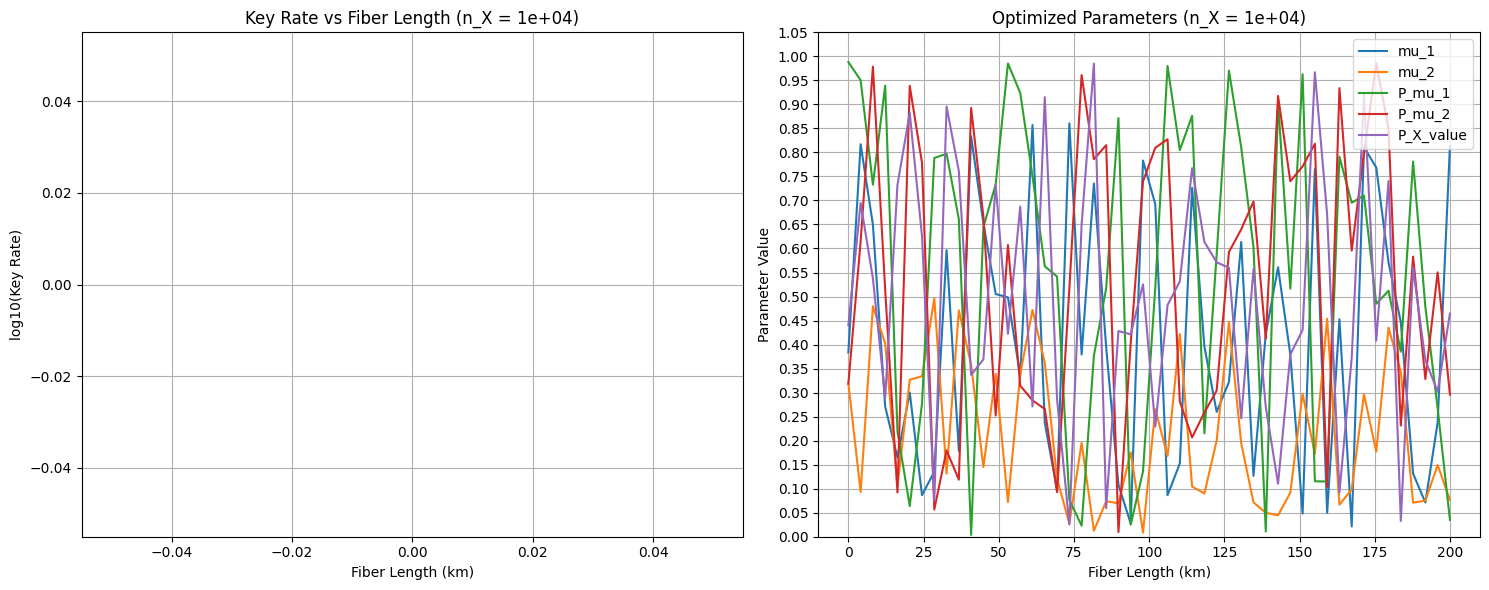


Plotting results for n_X = 1e+05
No data found for n_X = 100000

Plotting results for n_X = 1e+06
No data found for n_X = 1000000

Plotting results for n_X = 1e+07
No data found for n_X = 10000000

Plotting results for n_X = 1e+08
No data found for n_X = 100000000

Plotting results for n_X = 1e+09
No data found for n_X = 1000000000

Plotting results for n_X = 1e+10
No data found for n_X = 10000000000


In [25]:
# Step 2: Load and Plot Dataset
def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value
    """
    # Convert target_nx to string for dictionary key
    nx_key = str(float(target_nx))
    
    if nx_key not in data:
        
        print(f"No data found for n_X = {target_nx}")
        return
        
    filtered_data = data[nx_key]
    
    if not filtered_data:
        print(f"No valid results for n_X = {target_nx}")
        return
    
    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]
    
    # Create figure
    plt.figure(figsize=(15, 6))
    
    # Plot key rates
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10([max(kr, 1e-30) for kr in key_rates]))
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.grid(True)
    
    # Plot parameters
    plt.subplot(1, 2, 2)
    params = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
    for param in params:
        values = [entry["optimized_params"][param] for entry in filtered_data]
        plt.plot(fiber_lengths, values, label=param)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters (n_X = {target_nx:.0e})")
    plt.legend()
    
    # Set y-axis limits and ticks
    plt.ylim(0.0, 1.0)
    plt.yticks(np.arange(0.0, 1.1, 0.05))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Load the dataset
with open("qkd_dataset_comprehensive_100_20250131_003849.json", 'r') as f:
    dataset = json.load(f)

# Plot results for each n_X value
for nx in [10**s for s in range(4, 11, 1)]:
    print(f"\nPlotting results for n_X = {nx:.0e}")
    plot_for_nx(dataset, nx)


In [17]:
# def generate_comprehensive_dataset(Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, n_jobs=12):
#     """
#     Generate a comprehensive dataset using parallel processing
#     n_jobs: number of CPU cores to use (default=12)
#     """
#     # Create all combinations of L and n_X
#     combinations = [(L, float(n_X)) for L in Ls for n_X in n_X_values]
    
#     # Initialize dictionary to store results
#     categorized_dataset = {float(n_X): [] for n_X in n_X_values}
    
#     def process_single_combination(combo):
#         """Process a single (L, n_X) combination"""
#         L, n_X_float = combo
        
#         # Optimize parameters for this combination
#         result = optimize_single_instance(
#             (L, n_X_float), bounds, alpha, eta_Bob, P_dc_value, 
#             epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
#         )
        
#         if result is None or result[2] <= 0:  # Skip if optimization failed or key rate is invalid
#             return None
            
#         L_val, _, penalized_key_rate, optimized_params = result
#         mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = optimized_params
        
#         # Compute normalized parameters
#         return {
#             "n_X": n_X_float,
#             "fiber_length": float(L_val),
#             "e_1": float(L_val / 100),
#             "e_2": float(-jnp.log10(P_dc_value)),
#             "e_3": float(e_mis * 100),
#             "e_4": float(jnp.log10(n_X_float)),
#             "key_rate": float(max(penalized_key_rate, 1e-10)),
#             "optimized_params": {
#                 "mu_1": float(mu_1),
#                 "mu_2": float(mu_2),
#                 "P_mu_1": float(P_mu_1),
#                 "P_mu_2": float(P_mu_2),
#                 "P_X_value": float(P_X_value)
#             }
#         }
    
#     print(f"Starting parallel optimization with {n_jobs} cores...")
#     print(f"Total combinations to process: {len(combinations)}")
    
#     # Run parallel processing with progress bar
#     with tqdm_joblib(tqdm(desc="Generating Dataset", total=len(combinations))):
#         results = Parallel(n_jobs=n_jobs)(
#             delayed(process_single_combination)(combo) 
#             for combo in combinations
#         )
    
#     # Organize results into categorized dataset
#     for result in results:
#         if result is not None:  # Skip failed optimizations
#             n_X = result.pop("n_X")  # Remove and get n_X
#             categorized_dataset[n_X].append(result)
    
#     # Sort entries within each n_X category by fiber length
#     for n_X in categorized_dataset:
#         # categorized_dataset[n_X].sort(key=lambda x: x['fiber_length'])
#         categorized_dataset[n_X].sort(key=lambda x: x['L'])
    
#     # Save the dataset with timestamp
#     timestamp = time.strftime("%Y%m%d_%H%M%S")
#     filename = f'qkd_dataset_comprehensive_200_{timestamp}.json'
#     with open(filename, 'w') as f:
#         json.dump(categorized_dataset, f, indent=2)
    
#     print(f"\nDataset saved as: {filename}")
    
#     # Print statistics
#     print("\nDataset Statistics:")
#     for n_X in sorted(categorized_dataset.keys()):
#         print(f"n_X = {n_X:.0e}: {len(categorized_dataset[n_X])} data points")
    
#     return categorized_dataset

# # Usage
# Ls = jnp.linspace(1e-12, 200, 200)  # 200 points from 0 to 200 km
# n_X_values = [10**s for s in range(4, 6)]  # n_X from 10^4 to 10^14

# # Generate the comprehensive dataset with parallel processing
# dataset = generate_comprehensive_dataset(
#     Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, 
#     epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event,
#     n_jobs=12  # Use 12 CPU cores
# )

In [18]:
# # First iteration
# L, n_X, key_rate, optimized_params = optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, x0=initial_guess)

# print(f"First Iteration: L={L}, n_X={n_X}, Key Rate={key_rate}, Optimized Params={optimized_params}")

# # Second iteration using the result from the first iteration as the initial guess
# L, n_X, key_rate, optimized_params = optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, x0=optimized_params)

# print(f"Second Iteration: L={L}, n_X={n_X}, Key Rate={key_rate}, Optimized Params={optimized_params}")

In [19]:
# Define input parameters for a single instance
single_input = (Ls[0], n_X_values[0])  # Example: first fiber length and first n_X value

# Measure start time
start_time = time.time()

# Run the optimization for the single instance
L, n_X, optimized_key_rate, optimized_params = optimize_single_instance(
    single_input, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

# Measure end time
end_time = time.time()

# Output the results with parameter names
parameter_names = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
optimized_parameters = {name: value for name, value in zip(parameter_names, optimized_params)}

print(f"Optimization for a single instance took {end_time - start_time:.2f} seconds.")
print(f"Fiber Length: {L} km, Detected Events (n_X): {n_X}")
print(f"Optimized Key Rate: {optimized_key_rate:.3e}")
print("Optimized Parameters:")
for name, value in optimized_parameters.items():
    print(f"  {name}: {value:.6f}")

Optimization for a single instance took 1.55 seconds.
Fiber Length: 1e-12 km, Detected Events (n_X): 10000
Optimized Key Rate: nan
Optimized Parameters:
  mu_1: 0.371092
  mu_2: 0.400829
  P_mu_1: 0.450891
  P_mu_2: 0.663128
  P_X_value: 0.104743


Reasonableness Check for Execution Time:

A single optimization took 1.81 seconds. For 10,000 instances, the time would scale proportionally if no optimizations (e.g., batch parallelism) are applied:

$ \text{Total Time} = 1.81 \times 10,000 \approx 5.03 \, \text{hours}$ 

With 12 CPU cores using joblib, the time should reduce by approximately  1 / 12 :

$ \text{Total Time with 12 CPUs} \approx 5.03 / 12 \approx 25.13 \, \text{minutes}$


## Parallel Dataset Generation Using joblib

## Category in terms of $n_X$

	1.	Using a Dictionary for Categorization:
	•	A dictionary (categorized_dataset) is used to store results grouped by n_X.
	•	The defaultdict(list) automatically initializes an empty list for each unique n_X value.

	2.	Processing and Normalization:
	•	The same normalization is applied to the fiber length (e_1), dark count probability (e_2), misalignment error (e_3), and number of detected pulses (e_4).
	•	Data is appended under its respective n_X category.

	3.	Skipping Invalid Data:
	•	Entries with non-positive key rates are excluded to ensure the dataset contains only valid values.
	
	4.	Efficient Parallel Execution:
	•	joblib.Parallel is used to optimize data processing across multiple CPU cores.


In [20]:
def generate_comprehensive_dataset(Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, n_jobs=12):
    """
    Generate a comprehensive dataset using parallel processing
    n_jobs: number of CPU cores to use (default=12)
    """
    # Create all combinations of L and n_X
    combinations = [(L, float(n_X)) for L in Ls for n_X in n_X_values]
    
    # Initialize dictionary to store results
    categorized_dataset = {float(n_X): [] for n_X in n_X_values}
    
    def process_single_combination(combo):
        """Process a single (L, n_X) combination"""
        L, n_X_float = combo
        
        # Optimize parameters for this combination
        result = optimize_single_instance(
            (L, n_X_float), bounds, alpha, eta_Bob, P_dc_value, 
            epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
        )
        
        if result is None or result[2] <= 0:  # Skip if optimization failed or key rate is invalid
            return None
            
        L_val, _, penalized_key_rate, optimized_params = result
        mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = optimized_params
        
        # Compute normalized parameters
        return {
            "n_X": n_X_float,
            "fiber_length": float(L_val),
            "e_1": float(L_val / 100),
            "e_2": float(-jnp.log10(P_dc_value)),
            "e_3": float(e_mis * 100),
            "e_4": float(jnp.log10(n_X_float)),
            "key_rate": float(max(penalized_key_rate, 1e-10)),
            "optimized_params": {
                "mu_1": float(mu_1),
                "mu_2": float(mu_2),
                "P_mu_1": float(P_mu_1),
                "P_mu_2": float(P_mu_2),
                "P_X_value": float(P_X_value)
            }
        }
    
    print(f"Starting parallel optimization with {n_jobs} cores...")
    print(f"Total combinations to process: {len(combinations)}")
    
    # Run parallel processing with progress bar
    with tqdm_joblib(tqdm(desc="Generating Dataset", total=len(combinations))):
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_single_combination)(combo) 
            for combo in combinations
        )
    
    # Organize results into categorized dataset
    for result in results:
        if result is not None:  # Skip failed optimizations
            n_X = result.pop("n_X")  # Remove and get n_X
            categorized_dataset[n_X].append(result)
    
    # Sort entries within each n_X category by fiber length
    for n_X in categorized_dataset:
        categorized_dataset[n_X].sort(key=lambda x: x['fiber_length'])
    
    # Save the dataset with timestamp
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f'qkd_dataset_comprehensive_100_{timestamp}.json'
    with open(filename, 'w') as f:
        json.dump(categorized_dataset, f, indent=2)
    
    print(f"\nDataset saved as: {filename}")
    
    # Print statistics
    print("\nDataset Statistics:")
    for n_X in sorted(categorized_dataset.keys()):
        print(f"n_X = {n_X:.0e}: {len(categorized_dataset[n_X])} data points")
    
    return categorized_dataset

# Usage
Ls = jnp.linspace(0, 200, 50)  # 1000 points from 5 to 200 km
n_X_values = [10**4] # [10**s for s in range(4, 10)]  # n_X from 10^4 to 10^14

# Generate the comprehensive dataset with parallel processing
dataset = generate_comprehensive_dataset(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, 
    epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event,
    n_jobs=12  # Use 12 CPU cores
)

Starting parallel optimization with 12 cores...
Total combinations to process: 50


Generating Dataset:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()



Dataset saved as: qkd_dataset_comprehensive_100_20250131_003849.json

Dataset Statistics:
n_X = 1e+04: 50 data points


In [21]:
# # Step 2: Load and Plot Dataset
# def plot_for_nx(data, target_nx):
#     """
#     Plot results for a specific n_X value
#     """
#     # Convert target_nx to string for dictionary key
#     nx_key = str(float(target_nx))
    
#     if nx_key not in data:
        
#         print(f"No data found for n_X = {target_nx}")
#         return
        
#     filtered_data = data[nx_key]
    
#     if not filtered_data:
#         print(f"No valid results for n_X = {target_nx}")
#         return
    
#     # Extract data
#     fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
#     key_rates = [entry["key_rate"] for entry in filtered_data]
    
#     # Create figure
#     plt.figure(figsize=(15, 6))
    
#     # Plot key rates
#     plt.subplot(1, 2, 1)
#     plt.plot(fiber_lengths, np.log10([max(kr, 1e-30) for kr in key_rates]))
#     plt.xlabel("Fiber Length (km)")
#     plt.ylabel("log10(Key Rate)")
#     plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
#     plt.grid(True)
    
#     # Plot parameters
#     plt.subplot(1, 2, 2)
#     params = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
#     for param in params:
#         values = [entry["optimized_params"][param] for entry in filtered_data]
#         plt.plot(fiber_lengths, values, label=param)
    
#     plt.xlabel("Fiber Length (km)")
#     plt.ylabel("Parameter Value")
#     plt.title(f"Optimized Parameters (n_X = {target_nx:.0e})")
#     plt.legend()
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
#     plt.show()


# with open("qkd_dataset_comprehensive_100_20250127_232545.json", 'r') as f:
#     dataset = json.load(f)

# # with open("qkd_dataset_comprehensive_100_20250127_132054.json", 'r') as f:
# #     dataset = json.load(f)

# # Plot results for each n_X value
# for nx in [10**s for s in range(4, 11, 1)]:
#     print(f"\nPlotting results for n_X = {nx:.0e}")
#     plot_for_nx(dataset, nx)

Generating Dataset:   0%|          | 0/50 [00:14<?, ?it/s]


Plotting results for n_X = 1e+04


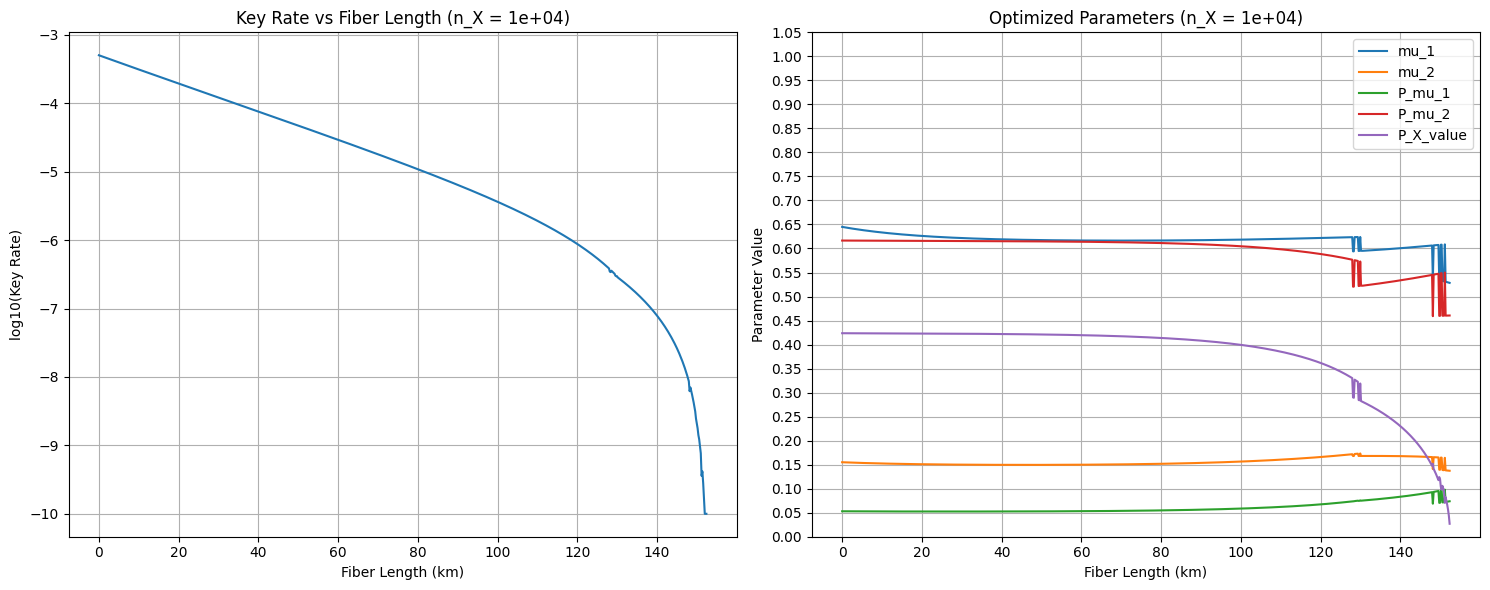

Initial parameter values (L=0) for n_X = 1e+04:
mu_1: 0.6449842981755858
mu_2: 0.15505191239034832
P_mu_1: 0.05297140511545002
P_mu_2: 0.6165263828598415
P_X_value: 0.4236321693764814

Plotting results for n_X = 1e+05


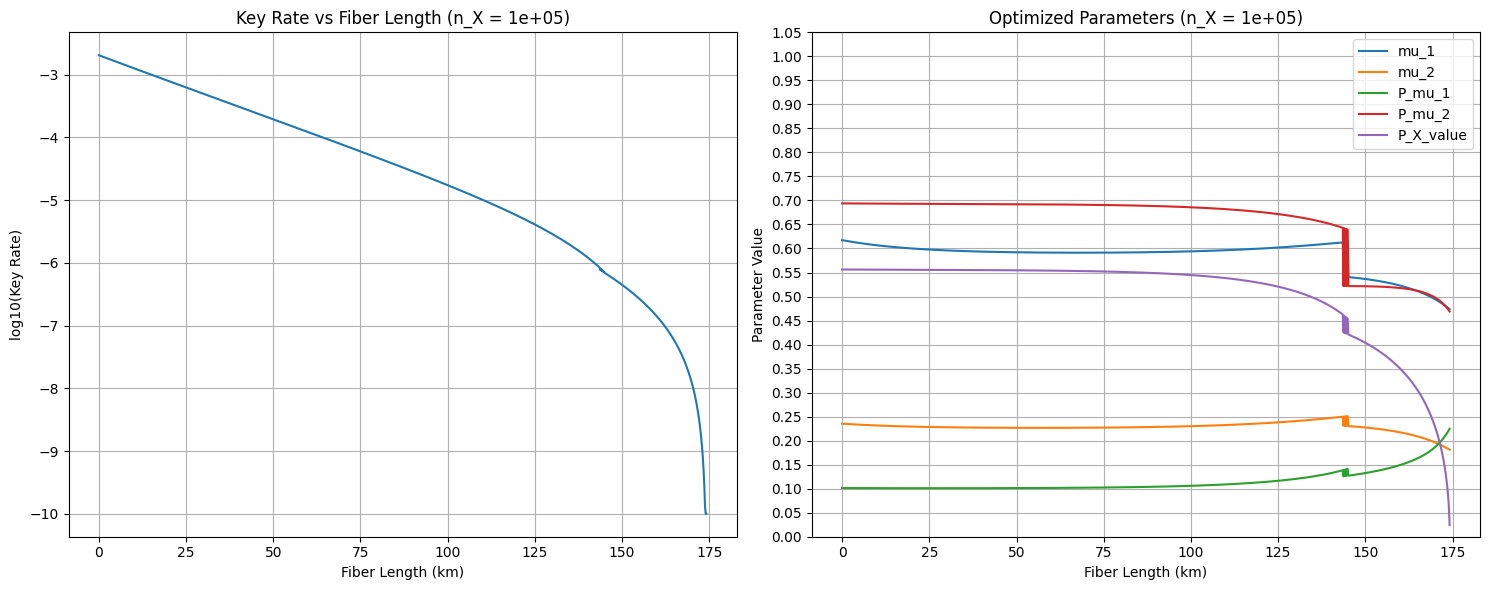

Initial parameter values (L=0) for n_X = 1e+05:
mu_1: 0.6173924208039082
mu_2: 0.23532137581450116
P_mu_1: 0.10134711172218064
P_mu_2: 0.6938969325199462
P_X_value: 0.5562819051290366

Plotting results for n_X = 1e+06


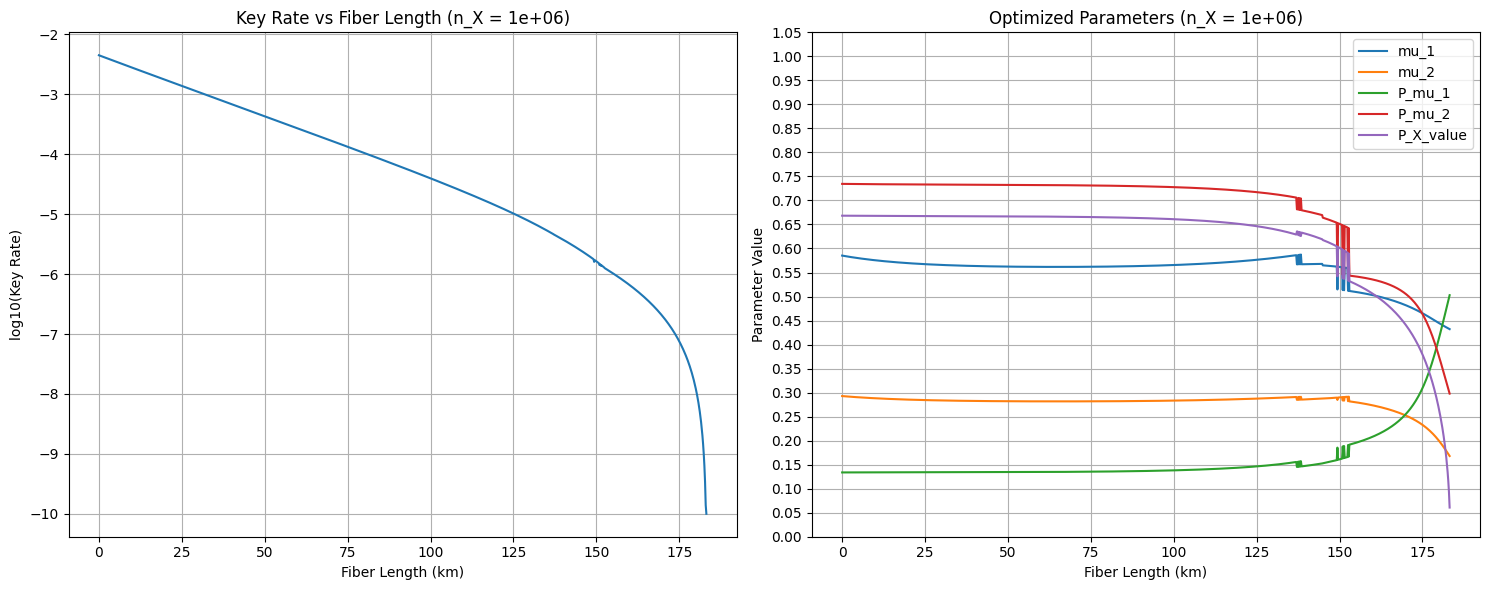

Initial parameter values (L=0) for n_X = 1e+06:
mu_1: 0.5852380481456254
mu_2: 0.29277189990141783
P_mu_1: 0.1338319114525561
P_mu_2: 0.7345277510050099
P_X_value: 0.6682966125409111

Plotting results for n_X = 1e+07


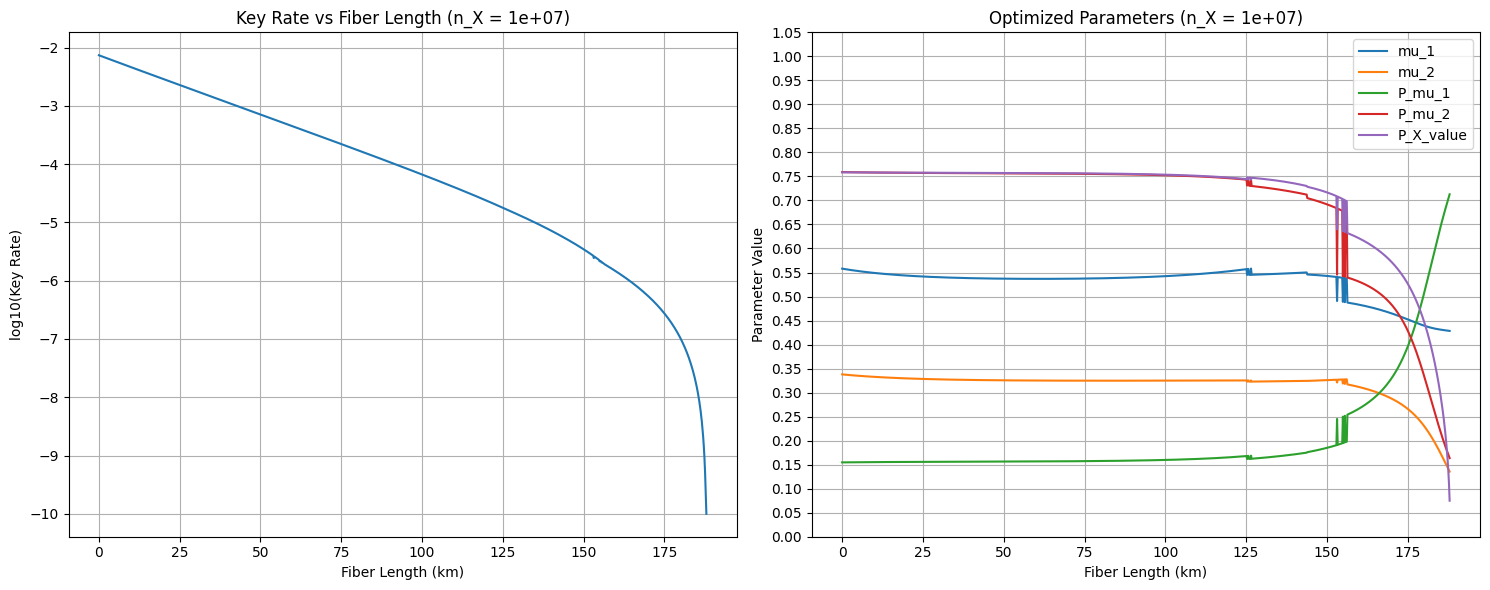

Initial parameter values (L=0) for n_X = 1e+07:
mu_1: 0.558046322624836
mu_2: 0.33792065141025296
P_mu_1: 0.15476882022705224
P_mu_2: 0.7591422335165772
P_X_value: 0.7585003347362045

Plotting results for n_X = 1e+08


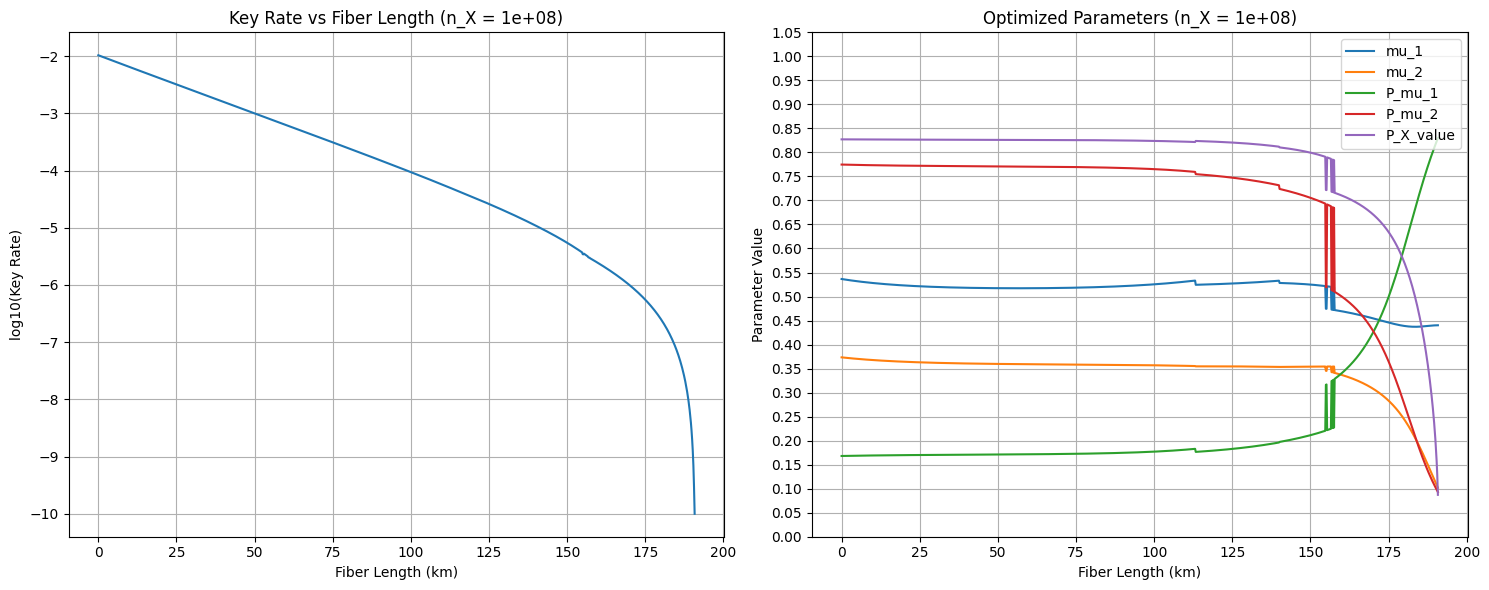

Initial parameter values (L=0) for n_X = 1e+08:
mu_1: 0.5364861703953097
mu_2: 0.37339421560156855
P_mu_1: 0.1680822476943225
P_mu_2: 0.7747348289061318
P_X_value: 0.8272069986290436

Plotting results for n_X = 1e+09


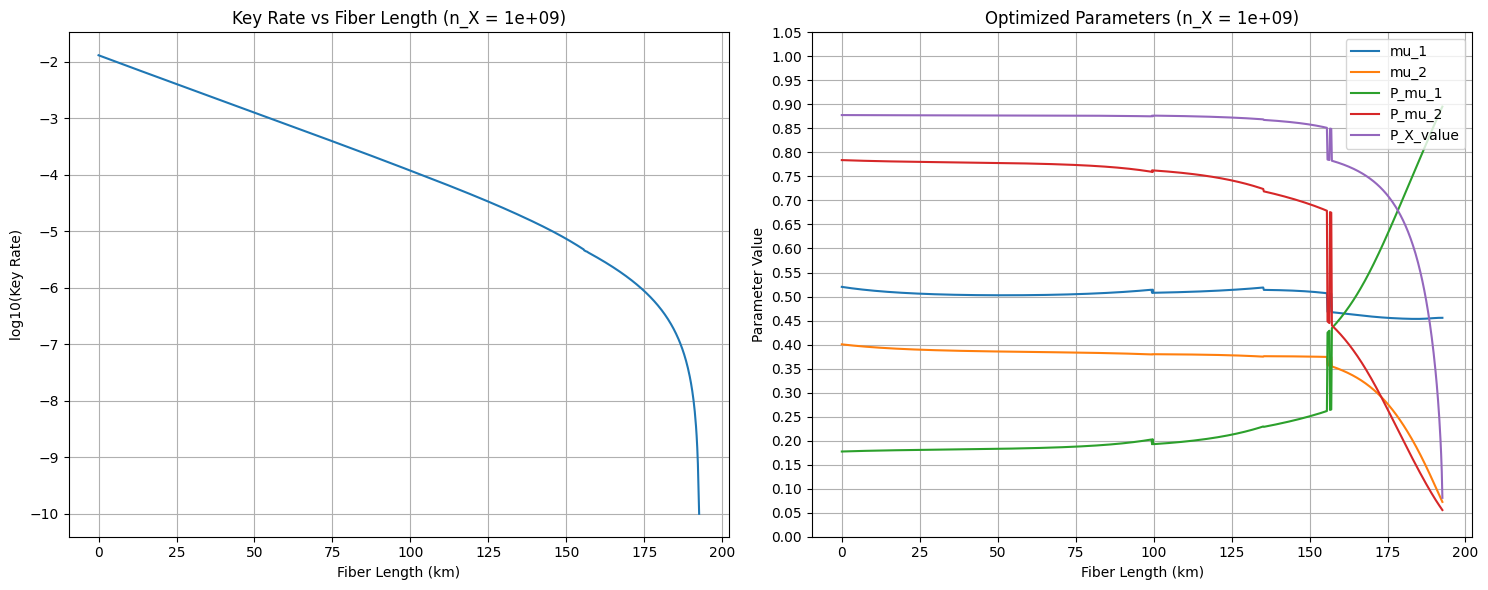

Initial parameter values (L=0) for n_X = 1e+09:
mu_1: 0.5200996852355406
mu_2: 0.4004550923142661
P_mu_1: 0.17740352413970462
P_mu_2: 0.7840106122018755
P_X_value: 0.8777691118400627

Plotting results for n_X = 1e+10
No data found for n_X = 10000000000
No data found for n_X = 10000000000


In [22]:
# Step 2: Load and Plot Dataset
def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value
    """
    # Convert target_nx to string for dictionary key
    nx_key = str(float(target_nx))
    
    if nx_key not in data:
        
        print(f"No data found for n_X = {target_nx}")
        return
        
    filtered_data = data[nx_key]
    
    if not filtered_data:
        print(f"No valid results for n_X = {target_nx}")
        return
    
    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]
    
    # Create figure
    plt.figure(figsize=(15, 6))
    
    # Plot key rates
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10([max(kr, 1e-30) for kr in key_rates]))
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.grid(True)
    
    # Plot parameters
    plt.subplot(1, 2, 2)
    params = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
    for param in params:
        values = [entry["optimized_params"][param] for entry in filtered_data]
        plt.plot(fiber_lengths, values, label=param)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters (n_X = {target_nx:.0e})")
    plt.legend()
    
    # Set y-axis limits and ticks
    plt.ylim(0.0, 1.0)
    plt.yticks(np.arange(0.0, 1.1, 0.05))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Load the dataset
with open("qkd_dataset_comprehensive_100_20250127_232545.json", 'r') as f:
    dataset = json.load(f)

# Function to print initial parameter values (L=0) for a specific n_X value
def print_initial_params(data, target_nx):
    """
    Print initial parameter values at L=0 for a specific n_X value
    """
    # Convert target_nx to string for dictionary key
    nx_key = str(float(target_nx))
    
    if nx_key not in data:
        print(f"No data found for n_X = {target_nx}")
        return
        
    filtered_data = data[nx_key]
    
    if not filtered_data:
        print(f"No valid results for n_X = {target_nx}")
        return
    
    # Find the entry where fiber_length is 0
    initial_entry = next((entry for entry in filtered_data if entry["fiber_length"] == 0), None)
    
    if initial_entry is None:
        print(f"No data found for L=0 at n_X = {target_nx}")
        return
    
    # Extract and print initial parameter values
    initial_params = initial_entry["optimized_params"]
    print(f"Initial parameter values (L=0) for n_X = {target_nx:.0e}:")
    for param in ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]:
        print(f"{param}: {initial_params[param]}")

# Load the dataset
with open("qkd_dataset_comprehensive_100_20250127_232545.json", 'r') as f:
    dataset = json.load(f)

# Plot results for each n_X value and print initial parameter values
for nx in [10**s for s in range(4, 11, 1)]:
    print(f"\nPlotting results for n_X = {nx:.0e}")
    plot_for_nx(dataset, nx)
    # plot_for_nx(dataset, nx)
    print_initial_params(dataset, nx)

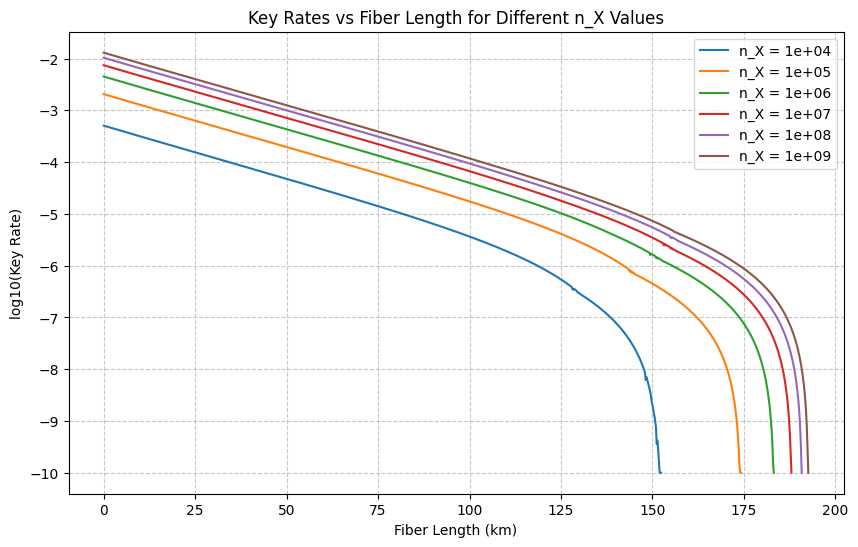

In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
with open("qkd_dataset_comprehensive_100_20250127_232545.json", 'r') as f:
    dataset = json.load(f)

def plot_all_key_rates(dataset):
    plt.figure(figsize=(10, 6))
    
    # Use a colormap for different n_X values
    cmap = plt.cm.tab10  # You can choose other colormaps like 'tab20', 'viridis', etc.
    nx_values = sorted([float(nx) for nx in dataset.keys()])
    num_colors = len(nx_values)
    
    for i, nx in enumerate(nx_values):
        nx_key = str(float(nx))
        data = dataset[nx_key]
        
        if data:
            # Extract and sort by fiber length
            fiber_lengths = [entry["fiber_length"] for entry in data]
            key_rates = [entry["key_rate"] for entry in data]
            
            # Sort data points by fiber length
            sorted_indices = np.argsort(fiber_lengths)
            sorted_lengths = [fiber_lengths[i] for i in sorted_indices]
            sorted_rates = [key_rates[i] for i in sorted_indices]
            
            # Plot with scientific notation in legend
            plt.plot(sorted_lengths, 
                    np.log10([max(kr, 1e-30) for kr in sorted_rates]), 
                    color=cmap(i % num_colors),
                    label=f'n_X = {nx:.0e}')
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title("Key Rates vs Fiber Length for Different n_X Values")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Save the figure
    plt.savefig("all_key_rates.png", dpi=300, bbox_inches="tight")
    plt.show()

# Create the plot
plot_all_key_rates(dataset)

The script runs the function optimize_single_instance() with a single set of input values (Ls[0] and n_X_values[0]), along with the necessary parameters. 

	•	The execution time is measured and printed.

The script uses the measured runtime for one instance to estimate the total time required to process all total_points = 10,000 data points in parallel using parallel_jobs = 12. 

	•	The estimated total runtime is printed in hours.

Parameter Space Definition:

	•	The fiber lengths (Ls) are defined in the range of 1 to 200 km with 100 evenly spaced points.
•	The detected events (n_X_values) are logarithmically spaced from $10^6$￼to $10^{12}$￼, also with 100 points.

Profiling (Optional Debugging):

	•	The script profiles a single optimization instance using cProfile.run(). This step is useful for debugging performance issues but does not contribute to data generation directly.

Raw Dataset Generation:
	
•	The function generate_dataset() is called, which presumably generates key rate values for each combination of Ls and n_X_values based on the provided system parameters (e.g., alpha, eta_Bob, P_dc_value, etc.).

	•	This function should iterate over all combinations of the two parameter arrays, producing a dataset of key rate values.

Filtering Negative Key Rates:

	•	The raw dataset entries are filtered to remove any with non-positive key rates. Only entries where entry["key_rate"] > 0 are retained, ensuring meaningful data.

Serialization to JSON:

	•	The filtered dataset is converted to a JSON-serializable format to ensure compatibility for saving or further processing.

Saving the Data:

	•	The filtered dataset is saved to a JSON file (total_training_dataset.json), making it available for further analysis.

Will This Generate Data Points?

Yes, if the function generate_dataset() is correctly implemented and functional, the script should generate a substantial number of data points. Given the defined ranges, the total number of raw data points before filtering would be:
￼

However, the final number of data points saved depends on the filtering step, which removes entries with non-positive key rates. If too many entries are filtered out, it might reduce the dataset significantly.

Potential Issues to Watch For:

	•	Ensure generate_dataset() is correctly implemented to avoid empty results.

	•	The filtering criteria (key_rate > 0) may remove too many points if parameters are not optimally chosen.

	•	The file-writing step requires that the data be correctly converted to a serializable format, otherwise it may fail.

In [24]:
# Define parameter space
Ls = jnp.linspace(1, 200, 10)  # Fiber lengths (5 km to 200 km)
n_X_values = jnp.logspace(6, 7, 10)  # Detected events (10^6 to 10^12)

# Profile a single optimization instance (optional debugging)
import cProfile
cProfile.run("optimize_single_instance((Ls[0], n_X_values[0]), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)")

# Measure total dataset generation time
import time
start_time = time.time()

# Step 1: Generate the raw dataset
raw_dataset = generate_dataset_by_n_X(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

# Step 2: Filter out entries with non-positive key rates
# Filter out entries with negative key rates
filtered_dataset = [entry for entry in raw_dataset if entry["key_rate"] > 0]

end_time = time.time()

# Step 3: Convert the filtered dataset to a JSON-serializable format
serializable_dataset = convert_to_serializable(filtered_dataset)

# Step 4: Save the filtered dataset to a JSON file
output_filename = "total_training_dataset.json"
with open(output_filename, "w") as f:
    json.dump(serializable_dataset, f)

print(f"Filtered dataset saved as '{output_filename}'.")

         3198906 function calls (3190312 primitive calls) in 2.221 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.216    2.216 943278368.py:1(optimize_single_instance)
        6    0.000    0.000    0.000    0.000 943278368.py:38(<genexpr>)
    10187    0.118    0.000    1.603    0.000 943278368.py:4(wrapped_objective)
       44    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        4    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    2.224    2.224 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 <string>:2(__hash__)
      462    0.000    0.000    0.000    0.000 <string>:2(__init__)
        5    0.000    0.000    0.008    0.002 QKD_Functions.py:1043(calculate_factorial)
        1    0.000    0.000    0.001    0.001 QKD_Functions.py:1050(calculate_eta_ch)
        1    0.000    0.000    0.000    

NameError: name 'generate_dataset_by_n_X' is not defined

In [25]:
# print(f"Raw dataset size: {len(raw_dataset)}")
# key_rates = [entry["key_rate"] for entry in raw_dataset]
# print(f"Number of negative key rates in the dataset: {sum(kr <= 0 for kr in key_rates)}")
# print(f"Number of positive key rates in the dataset: {sum(kr > 0 for kr in key_rates)}")

## $n_X = 10^6$

In [26]:
# # Load the dataset
# with open("total_training_dataset.json", "r") as f:
#     data = json.load(f)

# # Filter dataset for n_X = 10^6
# filtered_data = [item for item in data if item["e_4"] == 1e6]  # Ensure the value matches 1e6

# # Extract fiber lengths and key rates
# e_1 = jnp.array([item["e_1"] * 100 for item in filtered_data])  # Denormalize fiber lengths (convert to km)
# key_rate = jnp.array([item["key_rate"] for item in filtered_data])  # Extract key rates

# # Extract optimized parameters
# mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in filtered_data])  # Access nested keys
# mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in filtered_data])
# P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in filtered_data])
# P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in filtered_data])
# P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in filtered_data])

# # Sort by fiber length for smooth plotting
# sorted_indices = jnp.argsort(e_1)
# e_1_sorted = e_1[sorted_indices]
# key_rate_sorted = key_rate[sorted_indices]
# mu_1_sorted = mu_1[sorted_indices]
# mu_2_sorted = mu_2[sorted_indices]
# P_mu_1_sorted = P_mu_1[sorted_indices]
# P_mu_2_sorted = P_mu_2[sorted_indices]
# P_X_value_sorted = P_X_value[sorted_indices]

# # Plot the data
# plt.figure(figsize=(15, 6))

# # Left plot: Penalized Key Rate
# plt.subplot(1, 2, 1)
# plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
# plt.xlabel("Fiber Length (km)")
# plt.ylabel("log10(Penalized Key Rate)")
# plt.title("Penalized Key Rate vs Fiber Length (n_X = 10^6)")
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.legend()

# # Right plot: Optimized Parameters
# plt.subplot(1, 2, 2)
# plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
# plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
# plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
# plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
# plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
# plt.xlabel("Fiber Length (km)")
# plt.ylabel("Optimized Parameters")
# plt.title("Optimized Parameters vs Fiber Length (n_X = 10^6)")
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.legend()

# # Save the figure
# plt.tight_layout()
# plt.savefig("optimized_parameters_nX_10e6.png", dpi=300, bbox_inches="tight")  # Save with high resolution
# plt.show()

In [10]:
# Define parameter space
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths
n_X_values = jnp.array([1e6])  # Single value for n_X

import cProfile
cProfile.run("optimize_single_instance((Ls[0], n_X_values[0]), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)")

# Measure total dataset generation time
import time
start_time = time.time()

dataset = generate_dataset(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

end_time = time.time()
print(f"Dataset generation completed in {(end_time - start_time) / 60:.2f} minutes.")

# Convert dataset to a JSON-serializable format
serializable_dataset = convert_to_serializable(dataset)

# Save to JSON
output_filename = "training_dataset.json"
with open(output_filename, "w") as f:
    json.dump(serializable_dataset, f)

print(f"Dataset saved as '{output_filename}'.")

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract fiber lengths and key rates
e_1 = jnp.array([item["e_1"] * 100 for item in data])  # Denormalize fiber lengths (convert to km)
key_rate = jnp.array([item["key_rate"] for item in data])  # Correct key name

# Extract optimized parameters
mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in data])  # Access nested keys
mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in data])
P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in data])
P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in data])
P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in data])

# Sort by fiber length for smooth plotting
sorted_indices = jnp.argsort(e_1)
e_1_sorted = e_1[sorted_indices]
key_rate_sorted = key_rate[sorted_indices]
mu_1_sorted = mu_1[sorted_indices]
mu_2_sorted = mu_2[sorted_indices]
P_mu_1_sorted = P_mu_1[sorted_indices]
P_mu_2_sorted = P_mu_2[sorted_indices]
P_X_value_sorted = P_X_value[sorted_indices]

# Plot the data
plt.figure(figsize=(15, 6))

# Left plot: Penalized Key Rate
plt.subplot(1, 2, 1)
plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Penalized Key Rate)")
plt.title("Penalized Key Rate vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Right plot: Optimized Parameters
plt.subplot(1, 2, 2)
plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
plt.xlabel("Fiber Length (km)")
plt.ylabel("Optimized Parameters")
plt.title("Optimized Parameters vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
# Save the figure
plt.tight_layout()
plt.savefig("optimized_parameters_plot.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()

         6647 function calls (6572 primitive calls) in 0.017 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       14    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        4    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.017    0.017 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 <string>:2(__hash__)
        2    0.000    0.000    0.000    0.000 <string>:2(__init__)
        2    0.000    0.000    0.000    0.000 __init__.py:126(__init__)
        8    0.000    0.000    0.000    0.000 __init__.py:1424(debug)
       30    0.000    0.000    0.000    0.000 __init__.py:1689(isEnabledFor)
       10    0.000    0.000    0.000    0.000 __init__.py:437(_make)
       10    0.000    0.000    0.000    0.000 __init__.py:447(_replace)
        2    0.000    0.000    0.000    0.000 __init__.py:63(get_dialect_registry)
        2    0.000

NameError: name 'bounds' is not defined

In [ ]:
# Define parameter space
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths
n_X_values = jnp.array([1e9])  # Single value for n_X

import cProfile
cProfile.run("optimize_single_instance((Ls[0], n_X_values[0]), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)")

# Measure total dataset generation time
import time
start_time = time.time()

dataset = generate_dataset(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

end_time = time.time()
print(f"Dataset generation completed in {(end_time - start_time) / 60:.2f} minutes.")

# Convert dataset to a JSON-serializable format
serializable_dataset = convert_to_serializable(dataset)

# Save to JSON
output_filename = "training_dataset.json"
with open(output_filename, "w") as f:
    json.dump(serializable_dataset, f)

print(f"Dataset saved as '{output_filename}'.")

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract fiber lengths and key rates
e_1 = jnp.array([item["e_1"] * 100 for item in data])  # Denormalize fiber lengths (convert to km)
key_rate = jnp.array([item["key_rate"] for item in data])  # Correct key name

# Extract optimized parameters
mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in data])  # Access nested keys
mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in data])
P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in data])
P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in data])
P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in data])

# Sort by fiber length for smooth plotting
sorted_indices = jnp.argsort(e_1)
e_1_sorted = e_1[sorted_indices]
key_rate_sorted = key_rate[sorted_indices]
mu_1_sorted = mu_1[sorted_indices]
mu_2_sorted = mu_2[sorted_indices]
P_mu_1_sorted = P_mu_1[sorted_indices]
P_mu_2_sorted = P_mu_2[sorted_indices]
P_X_value_sorted = P_X_value[sorted_indices]

# Plot the data
plt.figure(figsize=(15, 6))

# Left plot: Penalized Key Rate
plt.subplot(1, 2, 1)
plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Penalized Key Rate)")
plt.title("Penalized Key Rate vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Right plot: Optimized Parameters
plt.subplot(1, 2, 2)
plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
plt.xlabel("Fiber Length (km)")
plt.ylabel("Optimized Parameters")
plt.title("Optimized Parameters vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
# Save the figure
plt.tight_layout()
plt.savefig("optimized_parameters_plot.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()

         479 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
       12    0.000    0.000    0.000    0.000 array.py:225(shape)
        6    0.000    0.000    0.000    0.000 array.py:233(ndim)
        4    0.000    0.000    0.000    0.000 array.py:241(sharding)
        2    0.000    0.000    0.000    0.000 array.py:299(__getitem__)
        2    0.000    0.000    0.000    0.000 array.py:557(_check_if_deleted)
        4    0.000    0.000    0.000    0.000 config.py:192(trace_context)
       82    0.000    0.000    0.000    0.000 config.py:278(value)
        4    0.000    0.000    0.000    0.000 contextlib.py:114(__enter__)
        4    0.000    0.000    0.000    0.000 contextlib.py:123(__exit__)
        4    0.000    0.000    0.000    0.000

NameError: name 'bounds' is not defined

In [ ]:
# Define the target value of n_X
n_X_target_log = jnp.log10(1e9)  # Log10 scale of n_X = 10^9

# Filter the dataset for entries matching n_X = 10^10 (based on e_4)
filtered_data = [
    item for item in data if jnp.isclose(item["e_4"], n_X_target_log, atol=1e-4)
]

if not filtered_data:
    print("No entries found matching n_X = 10^9")
else:
    print(f"Found {len(filtered_data)} entries for n_X = 10^9.")

    # Extract fiber lengths and key rates for the filtered data
    e_1_filtered = jnp.array([item["e_1"] * 100 for item in filtered_data])  # Denormalize fiber lengths
    key_rate_filtered = jnp.array([item["key_rate"] for item in filtered_data])

    # Extract optimized parameters
    mu_1_filtered = jnp.array([item["optimized_params"]["mu_1"] for item in filtered_data])
    mu_2_filtered = jnp.array([item["optimized_params"]["mu_2"] for item in filtered_data])
    P_mu_1_filtered = jnp.array([item["optimized_params"]["P_mu_1"] for item in filtered_data])
    P_mu_2_filtered = jnp.array([item["optimized_params"]["P_mu_2"] for item in filtered_data])
    P_X_value_filtered = jnp.array([item["optimized_params"]["P_X_value"] for item in filtered_data])

    # Sort by fiber length for smooth plotting
    sorted_indices_filtered = jnp.argsort(e_1_filtered)
    e_1_sorted_filtered = e_1_filtered[sorted_indices_filtered]
    key_rate_sorted_filtered = key_rate_filtered[sorted_indices_filtered]
    mu_1_sorted_filtered = mu_1_filtered[sorted_indices_filtered]
    mu_2_sorted_filtered = mu_2_filtered[sorted_indices_filtered]
    P_mu_1_sorted_filtered = P_mu_1_filtered[sorted_indices_filtered]
    P_mu_2_sorted_filtered = P_mu_2_filtered[sorted_indices_filtered]
    P_X_value_sorted_filtered = P_X_value_filtered[sorted_indices_filtered]

    # Create the filtered plot
    plt.figure(figsize=(15, 6))

    # Left plot: Penalized Key Rate
    plt.subplot(1, 2, 1)
    plt.plot(
        e_1_sorted_filtered,
        jnp.log10(jnp.clip(key_rate_sorted_filtered, a_min=1e-10, a_max=None)),
        label="Penalized Key Rate (log10)"
    )
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Penalized Key Rate)")
    plt.title("Penalized Key Rate vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Right plot: Optimized Parameters
    plt.subplot(1, 2, 2)
    plt.plot(e_1_sorted_filtered, mu_1_sorted_filtered, label="mu_1")
    plt.plot(e_1_sorted_filtered, mu_2_sorted_filtered, label="mu_2")
    plt.plot(e_1_sorted_filtered, P_mu_1_sorted_filtered, label="P_mu_1")
    plt.plot(e_1_sorted_filtered, P_mu_2_sorted_filtered, label="P_mu_2")
    plt.plot(e_1_sorted_filtered, P_X_value_sorted_filtered, label="P_X_value")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Optimized Parameters")
    plt.title("Optimized Parameters vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig("filtered_optimized_parameters_plot_nX_10_9.png", dpi=300, bbox_inches="tight")
    plt.show()

In [12]:
# Define the target value of n_X
n_X_target_log = jnp.log10(1e9)  # Log10 scale of n_X = 10^10

# Filter the dataset for entries matching n_X = 10^10 (based on e_4)
filtered_data = [
    item for item in data if jnp.isclose(item["e_4"], n_X_target_log, atol=1e-4)
]

if not filtered_data:
    print("No entries found matching n_X = 10^10.")
else:
    print(f"Found {len(filtered_data)} entries for n_X = 10^10.")

    # Extract fiber lengths and key rates for the filtered data
    e_1_filtered = jnp.array([item["e_1"] * 100 for item in filtered_data])  # Denormalize fiber lengths
    key_rate_filtered = jnp.array([item["key_rate"] for item in filtered_data])

    # Extract optimized parameters
    mu_1_filtered = jnp.array([item["optimized_params"]["mu_1"] for item in filtered_data])
    mu_2_filtered = jnp.array([item["optimized_params"]["mu_2"] for item in filtered_data])
    P_mu_1_filtered = jnp.array([item["optimized_params"]["P_mu_1"] for item in filtered_data])
    P_mu_2_filtered = jnp.array([item["optimized_params"]["P_mu_2"] for item in filtered_data])
    P_X_value_filtered = jnp.array([item["optimized_params"]["P_X_value"] for item in filtered_data])

    # Sort by fiber length for smooth plotting
    sorted_indices_filtered = jnp.argsort(e_1_filtered)
    e_1_sorted_filtered = e_1_filtered[sorted_indices_filtered]
    key_rate_sorted_filtered = key_rate_filtered[sorted_indices_filtered]
    mu_1_sorted_filtered = mu_1_filtered[sorted_indices_filtered]
    mu_2_sorted_filtered = mu_2_filtered[sorted_indices_filtered]
    P_mu_1_sorted_filtered = P_mu_1_filtered[sorted_indices_filtered]
    P_mu_2_sorted_filtered = P_mu_2_filtered[sorted_indices_filtered]
    P_X_value_sorted_filtered = P_X_value_filtered[sorted_indices_filtered]

    # Create the filtered plot
    plt.figure(figsize=(15, 6))

    # Left plot: Penalized Key Rate
    plt.subplot(1, 2, 1)
    plt.plot(
        e_1_sorted_filtered,
        jnp.log10(jnp.clip(key_rate_sorted_filtered, a_min=1e-10, a_max=None)),
        label="Penalized Key Rate (log10)"
    )
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Penalized Key Rate)")
    plt.title("Penalized Key Rate vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Right plot: Optimized Parameters
    plt.subplot(1, 2, 2)
    plt.plot(e_1_sorted_filtered, mu_1_sorted_filtered, label="mu_1")
    plt.plot(e_1_sorted_filtered, mu_2_sorted_filtered, label="mu_2")
    plt.plot(e_1_sorted_filtered, P_mu_1_sorted_filtered, label="P_mu_1")
    plt.plot(e_1_sorted_filtered, P_mu_2_sorted_filtered, label="P_mu_2")
    plt.plot(e_1_sorted_filtered, P_X_value_sorted_filtered, label="P_X_value")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Optimized Parameters")
    plt.title("Optimized Parameters vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig("filtered_optimized_parameters_plot_nX_10_10.png", dpi=300, bbox_inches="tight")
    plt.show()

NameError: name 'data' is not defined

In [13]:
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths
n_X_values = jnp.logspace(6, 10, 11)

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract fiber lengths and key rates
e_1 = jnp.array([item["e_1"] * 100 for item in data])  # Denormalize fiber lengths (convert to km)
key_rate = jnp.array([item["key_rate"] for item in data])  # Correct key name

# Extract optimized parameters
mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in data])  # Access nested keys
mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in data])
P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in data])
P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in data])
P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in data])

# Sort by fiber length for smooth plotting
sorted_indices = jnp.argsort(e_1)
e_1_sorted = e_1[sorted_indices]
key_rate_sorted = key_rate[sorted_indices]
mu_1_sorted = mu_1[sorted_indices]
mu_2_sorted = mu_2[sorted_indices]
P_mu_1_sorted = P_mu_1[sorted_indices]
P_mu_2_sorted = P_mu_2[sorted_indices]
P_X_value_sorted = P_X_value[sorted_indices]

# Plot the data
plt.figure(figsize=(15, 6))

# Left plot: Penalized Key Rate
plt.subplot(1, 2, 1)
plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Penalized Key Rate)")
plt.title("Penalized Key Rate vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Right plot: Optimized Parameters
plt.subplot(1, 2, 2)
plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
plt.xlabel("Fiber Length (km)")
plt.ylabel("Optimized Parameters")
plt.title("Optimized Parameters vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
# Save the figure
plt.tight_layout()
plt.savefig("optimized_parameters_plot.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'training_dataset.json'

In [14]:
# Define the parameters for optimization
L = 0  # Fiber length = 0
n_X = n_X_values[0]  # Use a default n_X value for the calculation

# Run optimization for L = 0
_, _, key_rate_L0, optimized_params_L0 = optimize_single_instance(
    (L, n_X), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

if key_rate_L0 is not None:
    print(f"Computed Key Rate at Fiber Length L = 0 km: {key_rate_L0:.2e}")
    print("Optimized Parameters for L = 0 km:")
    for name, value in zip(parameter_names, optimized_params_L0):
        print(f"  {name}: {value:.6f}")
else:
    print("Optimization failed for Fiber Length L = 0 km.")

NameError: name 'bounds' is not defined

In [15]:
with open("training_dataset.json", "r") as f:
    data = json.load(f)

print(data[0])  # Print the first item to inspect its structure

FileNotFoundError: [Errno 2] No such file or directory: 'training_dataset.json'

In [16]:
import json

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract the top 100 entries
top_100_entries = data[:100]

# Display the top 100 entries
for idx, entry in enumerate(top_100_entries, 1):
    print(f"Entry {idx}: {entry}")

FileNotFoundError: [Errno 2] No such file or directory: 'training_dataset.json'

In [ ]:
import json
import math

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Iterate through each entry
for idx, entry in enumerate(data, 1):
    for key, value in entry.items():
        # Check if value is a number and log10(value) > 0
        if isinstance(value, (int, float)) and value > 1:
            print(f"Entry {idx} Key '{key}': Value = {value}, log10(Value) = {math.log10(value):.2f}")

## Current Setup

49% of 10,000 iterations completed in 15 minutes. 

Processing speed: 5.16 iterations per second (it/s). 

Total Time Estimation (Current Setup): \
Total iterations: 10,000. \
Completed iterations:  10,000 \times 0.49 = 4,900 . \
Time to complete 4,900 iterations: 15 minutes (900 seconds). \
Estimated total time for 10,000 iterations: 

$\text{Total time} = \frac{\text{Total iterations}}{\text{Processing speed}} = \frac{10,000}{5.16} \approx 1,937 \text{ seconds (32 minutes)}$

So, approximately 32 minutes total is needed for the dataset generation with your current setup.

## Multiprocessing

Assumption:
12 CPU cores available (based on earlier discussions). \
Multiprocessing scales linearly with cores (ideal case, no overhead). 

Parallel Speed Calculation:

If multiprocessing scales ideally: 

$\text{Parallel speed} = \text{Single-threaded speed} \times \text{Number of cores}$


$\text{Parallel speed} = 5.16 \, \text{it/s} \times 12 \approx 61.92 \, \text{it/s}$


Parallel Time Calculation:


$\text{Total time (parallel)} = \frac{\text{Total iterations}}{\text{Parallel speed}} = \frac{10,000}{61.92} \approx 161.5 \, \text{seconds (2.7 minutes)}.$



# Reference
1. https://machinelearningmastery.com/dual-annealing-optimization-with-python/
2. https://en.wikipedia.org/wiki/Global_optimization
3. https://docs.scipy.org/doc/scipy/tutorial/optimize.html